# Analyzing Road Traffic Accident Data in Great Britain

## This code analyzes road traffic accident data from Great Britain to understand patterns and enhance road safety strategies. Data from four tables—accident, vehicle, casualty, and lsoa—was extracted for the year 2020. The analysis identified peak accident times during commuting hours and higher frequencies on Fridays. Specific patterns for different vehicle types and pedestrian accidents were also explored. Data cleaning involved addressing missing and outlier values using Python's Pandas library. The Apriori algorithm revealed significant associations impacting accident severity. Clustering analysis identified accident hotspots in the Yorkshire and the Humber region. Predictive models, including a Stacking Classifier, were developed to predict fatal injuries, providing insights for targeted road safety interventions and policy development.

In [1]:
!pip install imblearn

In [2]:
!pip install mlxtend

In [3]:
# For security
!pip install folium

In [4]:
!pip install gmplot

In [5]:
# Importing needed libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from imblearn.under_sampling import RandomUnderSampler
import scipy.stats as stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_selection import SelectKBest, f_classif
import folium


In [6]:

# Connect to the SQLite database
conn = sqlite3.connect("accident_data_v1.0.0_2023.db")

# Query to select data for the year 2020 from the accident table
query = "SELECT * FROM accident WHERE accident_year = 2020"

# Fetch data into a pandas DataFrame
accidents_df = pd.read_sql_query(query, conn)

# Query to select data for the year 2020 from the vehicle table
query_vehicle = "SELECT * FROM vehicle WHERE accident_year = 2020"

# Fetch data into a pandas DataFrame for the vehicle table
vehicle_df = pd.read_sql_query(query_vehicle, conn)

# Query to select data for the year 2020 from the casualty table
query_casualty = "SELECT * FROM casualty WHERE accident_year = 2020"

# Fetch data into a pandas DataFrame for the casualty table
casualty_df = pd.read_sql_query(query_casualty, conn)

# Query to select data for the year 2020 from the lsoa table
query_lsoa = "SELECT * FROM lsoa "

# Fetch data into a pandas DataFrame for the lsoa table
lsoa_df = pd.read_sql_query(query_lsoa, conn)

# Close the connection
conn.close()


In [7]:
# Print column names for the 'accident' table
print("Column names for the 'accident' table:")
print(accidents_df.columns)

# Print column names for the 'vehicle' table
print("\nColumn names for the 'vehicle' table:")
print(vehicle_df.columns)

# Print column names for the 'casualty' table
print("\nColumn names for the 'casualty' table:")
print(casualty_df.columns)

# Print column names for the 'lsoa' table
print("\nColumn names for the 'lsoa' table:")
print(lsoa_df.columns)


Column names for the 'accident' table:
Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location'],
      dtype='object')

Column names for the 'vehicle' tab

In [8]:
# Showing each table
#print(accidents_df)
#print(vehicle_df)
#print(casualty_df)
#print(lsoa_df)

In [9]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

In [10]:
accidents_df

accident_index  accident_year accident_reference  location_easting_osgr  \
0      2020010219808           2020          010219808               521389.0   
1      2020010220496           2020          010220496               529337.0   
2      2020010228005           2020          010228005               526432.0   
3      2020010228006           2020          010228006               538676.0   
4      2020010228011           2020          010228011               529324.0   
...              ...            ...                ...                    ...   
91194  2020991027064           2020          991027064               343034.0   
91195  2020991029573           2020          991029573               257963.0   
91196  2020991030297           2020          991030297               383664.0   
91197  2020991030900           2020          991030900               277161.0   
91198  2020991032575           2020          991032575               240402.0   

       location_northing_osgr  longitude   latitude  police_force  \
0                    175144.0  -0.254001  51.462262             1   
1                    176237.0  -0.139253  51.470327             1   
2                    182761.0  -0.178719  51.529614             1   
3                    184371.0  -0.001683  51.541210             1   
4                    181286.0  -0.137592  51.515704             1   
...                       ...        ...        ...           ...   
91194                731654.0  -2.926320  56.473539            99   
91195                658891.0  -4.267565  55.802353            99   
91196                810646.0  -2.271903  57.186317            99   
91197                674852.0  -3.968753  55.950940            99   
91198                681950.0  -4.561040  56.003843            99   

       accident_severity  number_of_vehicles  ...  \
0                      3                   1  ...   
1                      3                   1  ...   
2                      3                   1  ...   
3                      2                   1  ...   
4                      3                   1  ...   
...                  ...                 ...  ...   
91194                  2                   2  ...   
91195                  3                   1  ...   
91196                  2                   2  ...   
91197                  3                   2  ...   
91198                  3                   1  ...   

       pedestrian_crossing_physical_facilities light_conditions  \
0                                            9                1   
1                                            4                1   
2                                            0                4   
3                                            4                4   
4                                            0                4   
...                                        ...              ...   
91194                                        0                1   
91195                                        0                1   
91196                                        0                1   
91197                                        0                1   
91198                                        0                1   

       weather_conditions road_surface_conditions  special_conditions_at_site  \
0                       9                       9                           0   
1                       1                       1                           0   
2                       1                       2                           0   
3                       1                       1                           0   
4                       1                       1                           0   
...                   ...                     ...                         ...   
91194                   1                       1                           0   
91195                   1                       1                           0   
91196                   1        

In [11]:
vehicle_df

vehicle_index accident_index  accident_year accident_reference  \
0              681716  2020010219808           2020          010219808   
1              681717  2020010220496           2020          010220496   
2              681718  2020010228005           2020          010228005   
3              681719  2020010228006           2020          010228006   
4              681720  2020010228011           2020          010228011   
...               ...            ...            ...                ...   
167370         849086  2020991030297           2020          991030297   
167371         849087  2020991030297           2020          991030297   
167372         849088  2020991030900           2020          991030900   
167373         849089  2020991030900           2020          991030900   
167374         849090  2020991032575           2020          991032575   

        vehicle_reference  vehicle_type  towing_and_articulation  \
0                       1             9                        9   
1                       1             9                        0   
2                       1             9                        0   
3                       1             8                        0   
4                       1             9                        0   
...                   ...           ...                      ...   
167370                  1             9                        0   
167371                  2             5                        0   
167372                  1             9                        0   
167373                  2             1                        0   
167374                  1             9                        0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
0                       5                       1                     5  ...   
1                       4                       2                     6  ...   
2                      18                      -1                    -1  ...   
3                      18                       1                     5  ...   
4                      18                       3                     7  ...   
...                   ...                     ...                   ...  ...   
167370                  7                       8                     2  ...   
167371                 16                       6                     2  ...   
167372                  7                       8                     2  ...   
167373                 18                       6                     2  ...   
167374                  1                       8                     4  ...   

        journey_purpose_of_driver  sex_of_driver  age_of_driver  \
0                               6              2             32   
1                               2              1             45   
2                               6              3             -1   
3                               1              1             44   
4                               6              1             20   
...                           ...            ...            ...   
167370                          1              1             57   
167371                          5              1             38   
167372                          6              2             68   
167373                          6              1             76   
167374                          6              1             39   

        age_band_of_driver  engine_capacity_cc  propulsion_code  \
0                        6                1968                2   
1                        7                1395                1   
2                       -1                  -1               -1   
3                        7                1798                8   
4                        4                2993                2   
...                    ...                 ...              ...   
167370                   9                1968                2   


In [12]:
casualty_df

casualty_index accident_index  accident_year accident_reference  \
0               484748  2020010219808           2020          010219808   
1               484749  2020010220496           2020          010220496   
2               484750  2020010220496           2020          010220496   
3               484751  2020010228005           2020          010228005   
4               484752  2020010228006           2020          010228006   
...                ...            ...            ...                ...   
115579          600327  2020991027064           2020          991027064   
115580          600328  2020991029573           2020          991029573   
115581          600329  2020991030297           2020          991030297   
115582          600330  2020991030900           2020          991030900   
115583          600331  2020991032575           2020          991032575   

        vehicle_reference  casualty_reference  casualty_class  \
0                       1                   1               3   
1                       1                   1               3   
2                       1                   2               3   
3                       1                   1               3   
4                       1                   1               3   
...                   ...                 ...             ...   
115579                  2                   1               1   
115580                  1                   1               3   
115581                  2                   1               1   
115582                  2                   1               1   
115583                  1                   1               3   

        sex_of_casualty  age_of_casualty  age_band_of_casualty  \
0                     1               31                     6   
1                     2                2                     1   
2                     2                4                     1   
3                     1               23                     5   
4                     1               47                     8   
...                 ...              ...                   ...   
115579                1               11                     3   
115580                2               63                     9   
115581                1               38                     7   
115582                1               76                    11   
115583                1               48                     8   

        casualty_severity  pedestrian_location  pedestrian_movement  \
0                       3                    9                    5   
1                       3                    1                    1   
2                       3                    1                    1   
3                       3                    5                    9   
4                       2                    4                    1   
...                   ...                  ...                  ...   
115579                  2                    0                    0   
115580                  3                   10                    1   
115581                  2                    0                    0   
115582                  3                    0                    0   
115583                  3                    9                    9   

        car_passenger  bus_or_coach_passenger  \
0                   0                       0   
1                   0                       0   
2                   0                       0   
3                   0                       0   
4                   0                       0   
...               ...                     ...   
115579              0                       0   
115580              0                       0   
115581              0                       0   
115582              0                       0   
115583              0                       0   

        pedestrian_road_maintenance_worker  casualty_type  \
0                             

In [13]:
lsoa_df.head()

objectid   lsoa01cd             lsoa01nm            lsoa01nmw  \
0         1  E01000001  City of London 001A  City of London 001A   
1         2  E01000002  City of London 001B  City of London 001B   
2         3  E01000003  City of London 001C  City of London 001C   
3         4  E01000004  City of London 001D  City of London 001D   
4         5  E01000005  City of London 001E  City of London 001E   

    shape__area  shape__length                              globalid  
0  1.298652e+05    2635.772001  68cc6127-1008-4fbe-a16c-78fb089a7c43  
1  2.284189e+05    2707.986202  937edbc3-c1bf-4d35-b274-b0a1480a7c09  
2  5.905477e+04    1224.774479  2686dcaf-10b9-4736-92af-4788d4feaa69  
3  2.544551e+06   10718.466240  3c493140-0b3f-4b9a-b358-22011dc5fb89  
4  1.895782e+05    2275.809358  b569093d-788d-41be-816c-d6d7658b2311

### Checking and cleaning the data

In [14]:
# Check for missing values in the 'accident' table
print("Missing values in the 'accident' table:")
print(accidents_df.isnull().sum())

# Check for missing values in the 'vehicle' table
print("\nMissing values in the 'vehicle' table:")
print(vehicle_df.isnull().sum())

# Check for missing values in the 'casualty' table
print("\nMissing values in the 'casualty' table:")
print(casualty_df.isnull().sum())

# Check for missing values in the 'lsoa' table
print("\nMissing values in the 'lsoa' table:")
print(lsoa_df.isnull().sum())


Missing values in the 'accident' table:
accident_index                                  0
accident_year                                   0
accident_reference                              0
location_easting_osgr                          14
location_northing_osgr                         14
longitude                                      14
latitude                                       14
police_force                                    0
accident_severity                               0
number_of_vehicles                              0
number_of_casualties                            0
date                                            0
day_of_week                                     0
time                                            0
local_authority_district                        0
local_authority_ons_district                    0
local_authority_highway                         0
first_road_class                                0
first_road_number                               0
road_type 

In [15]:
#dropping 14 rows since its a small number compared to all rows
accidents_df=accidents_df.dropna()

### Are there significant hours of the day, and days of the week, on which accidents occur?

### significant hours of the day

C:\Users\juded\AppData\Local\Temp\ipykernel_10768\521618827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_df['hour'] = pd.to_datetime(accidents_df['time']).dt.hour


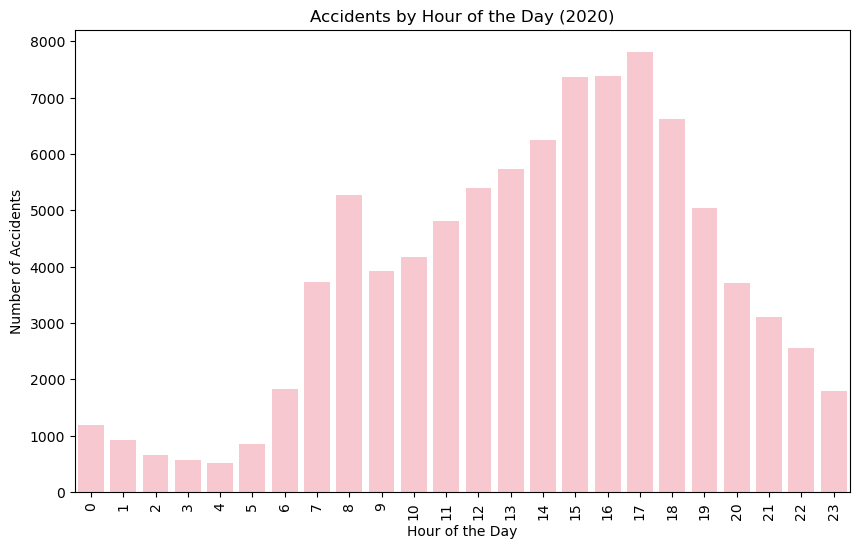

In [16]:
# Extract the hour from the 'time' column and create a new column for it
accidents_df['hour'] = pd.to_datetime(accidents_df['time']).dt.hour

# Count the number of accidents for each hour of the day
hourly_accidents = accidents_df['hour'].value_counts().sort_index()

# Visualize the data
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_accidents.index, y=hourly_accidents.values, color='pink')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Hour of the Day (2020)')
plt.xticks(rotation=90)
plt.show()


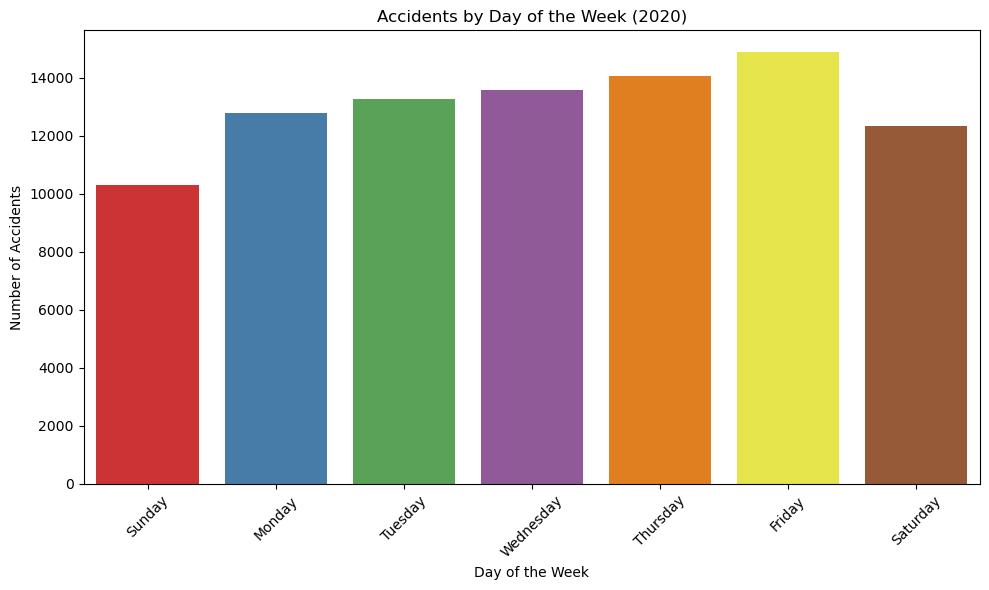

In [17]:

# Count the number of accidents for each day of the week
daily_accidents = accidents_df['day_of_week'].value_counts().sort_index()

# Define the names of the days of the week for better visualization
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Define a color palette for each day of the week
color_palette = sns.color_palette("Set1", len(days_of_week))

# Visualize the data
plt.figure(figsize=(10, 6))
sns.barplot(x=days_of_week, y=daily_accidents.values, palette=color_palette)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Day of the Week (2020)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()


### For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.

In [18]:
# combine vehicle type 2 and 3

In [19]:
# 1	Pedal cycle
# 2	Motorcycle 50cc and under
# 3	Motorcycle 125cc and under
# 4	Motorcycle over 125cc and up to 500cc
# 5	Motorcycle over 500cc


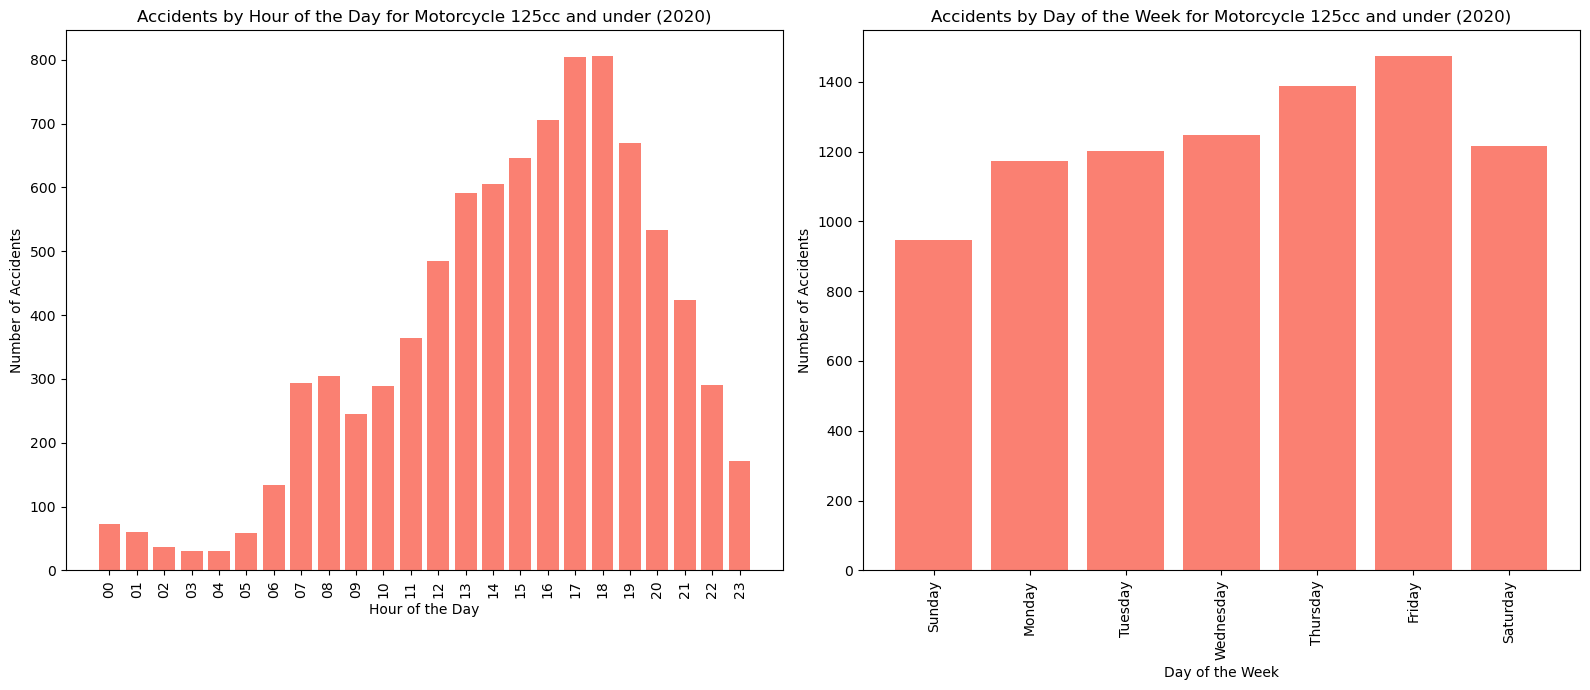

In [20]:
# Connect to the SQLite database
conn = sqlite3.connect("accident_data_v1.0.0_2023.db")

# Function to execute SQL query and get results as DataFrame
def execute_sql_query(query):
    return pd.read_sql_query(query, conn)

# Define the vehicle type of interest
motorcycle_type = ("2, 3", 'Motorcycle 125cc and under')

# Define custom color for the motorcycle type
motorcycle_color = 'salmon'  # Color for 'Motorcycle 125cc and under'

# Function to plot accidents by hour of the day for the specified motorcycle type
def plot_accidents_by_hour():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
    
    type_id, type_name = motorcycle_type
    query = f"""
        SELECT strftime('%H', a.time) AS hour, COUNT(*) AS num_accidents
        FROM accident a
        JOIN vehicle v ON a.accident_index = v.accident_index
        WHERE a.accident_year = 2020 AND v.vehicle_type IN ({type_id})
        GROUP BY hour
        ORDER BY hour;
    """
    result = execute_sql_query(query)

    if result.empty:
        print(f"No accidents for {type_name} in the year 2020.")
    else:
        # Plot for time
        ax_time = axes[0]
        ax_time.bar(result['hour'], result['num_accidents'], color=motorcycle_color)
        ax_time.set_xlabel('Hour of the Day')
        ax_time.set_ylabel('Number of Accidents')
        ax_time.set_title(f'Accidents by Hour of the Day for {type_name} (2020)')
        ax_time.set_xticks(range(24))
        ax_time.set_xticklabels(result['hour'], rotation=90)

        # Plot for day
        days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        query_day = f"""
            SELECT a.day_of_week, COUNT(*) AS num_accidents
            FROM accident a
            JOIN vehicle v ON a.accident_index = v.accident_index
            WHERE a.accident_year = 2020 AND v.vehicle_type IN ({type_id})
            GROUP BY a.day_of_week
            ORDER BY a.day_of_week;
        """
        result_day = execute_sql_query(query_day)

        if result_day.empty:
            print(f"No accidents for {type_name} in the year 2020.")
        else:
            ax_day = axes[1]
            ax_day.bar(days_of_week, result_day['num_accidents'], color=motorcycle_color)
            ax_day.set_xlabel('Day of the Week')
            ax_day.set_ylabel('Number of Accidents')
            ax_day.set_title(f'Accidents by Day of the Week for {type_name} (2020)')
            ax_day.set_xticks(range(7))
            ax_day.set_xticklabels(days_of_week, rotation=90)

    plt.tight_layout()
    plt.show()

# Execute and plot for the specified motorcycle type
plot_accidents_by_hour()

# Close the connection
conn.close()


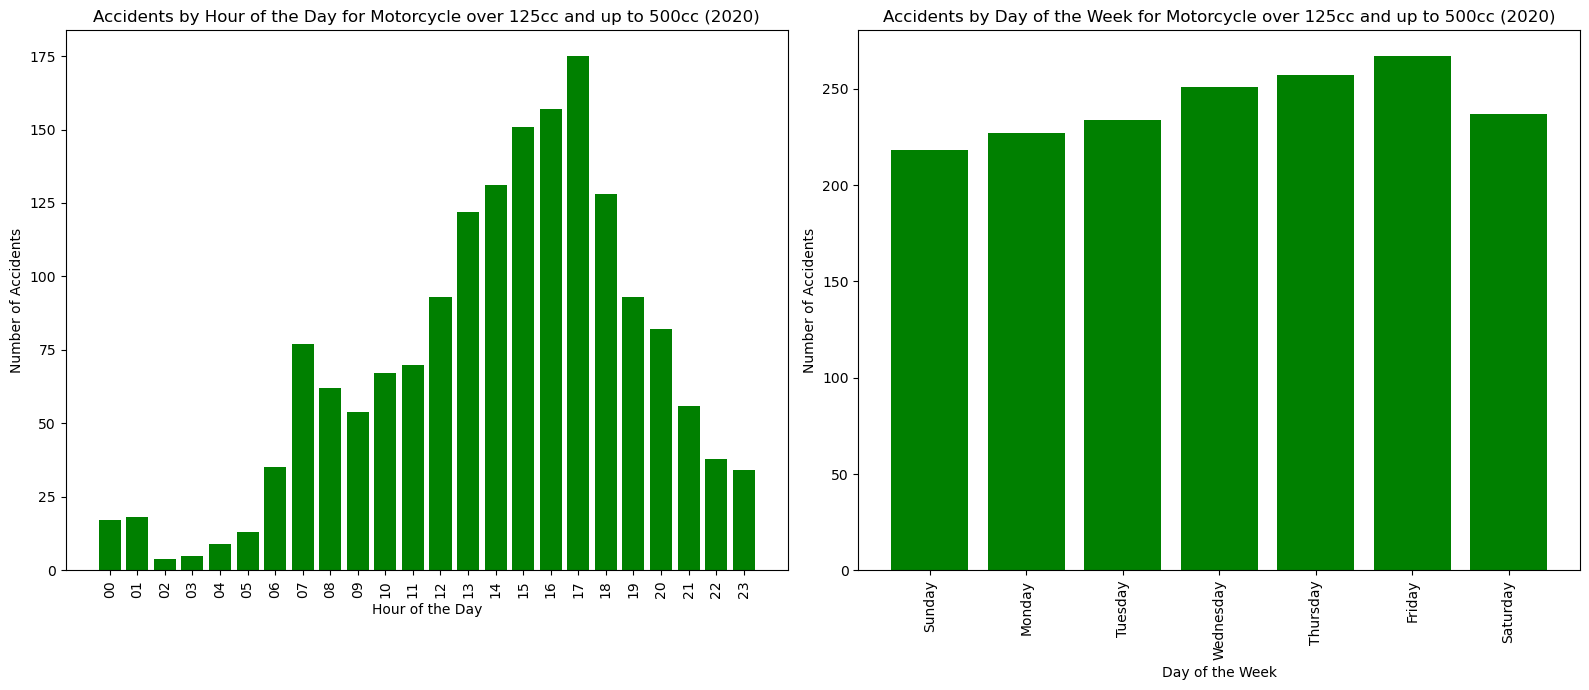

In [21]:
# Connect to the SQLite database
conn = sqlite3.connect("accident_data_v1.0.0_2023.db")

# Function to execute SQL query and get results as DataFrame
def execute_sql_query(query):
    return pd.read_sql_query(query, conn)

# Define the vehicle type of interest
motorcycle_type = (4, 'Motorcycle over 125cc and up to 500cc')

# Define custom color for the motorcycle type
motorcycle_color = {
    4: 'green'  # Color for 'Motorcycle over 125cc and up to 500cc'
}

# Function to plot accidents by hour of the day for the specified motorcycle type
def plot_accidents_by_hour():
    type_id, type_name = motorcycle_type
    query = f"""
        SELECT strftime('%H', a.time) AS hour, COUNT(*) AS num_accidents
        FROM accident a
        JOIN vehicle v ON a.accident_index = v.accident_index
        WHERE a.accident_year = 2020 AND v.vehicle_type IN ({type_id})
        GROUP BY hour
        ORDER BY hour;
    """
    result = execute_sql_query(query)

    if result.empty:
        print(f"No accidents for {type_name} in the year 2020.")
    else:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
        
        # Plot for time
        ax_time = axes[0]
        ax_time.bar(result['hour'], result['num_accidents'], color=motorcycle_color[type_id])
        ax_time.set_xlabel('Hour of the Day')
        ax_time.set_ylabel('Number of Accidents')
        ax_time.set_title(f'Accidents by Hour of the Day for {type_name} (2020)')
        ax_time.set_xticks(range(24))
        ax_time.set_xticklabels(result['hour'], rotation=90)
        
        # Plot for day
        days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        query_day = f"""
            SELECT a.day_of_week, COUNT(*) AS num_accidents
            FROM accident a
            JOIN vehicle v ON a.accident_index = v.accident_index
            WHERE a.accident_year = 2020 AND v.vehicle_type IN ({type_id})
            GROUP BY a.day_of_week
            ORDER BY a.day_of_week;
        """
        result_day = execute_sql_query(query_day)

        if result_day.empty:
            print(f"No accidents for {type_name} in the year 2020.")
        else:
            ax_day = axes[1]
            ax_day.bar(days_of_week, result_day['num_accidents'], color=motorcycle_color[type_id])
            ax_day.set_xlabel('Day of the Week')
            ax_day.set_ylabel('Number of Accidents')
            ax_day.set_title(f'Accidents by Day of the Week for {type_name} (2020)')
            ax_day.set_xticks(range(7))
            ax_day.set_xticklabels(days_of_week, rotation=90)

        plt.tight_layout()
        plt.show()

# Execute and plot for the specified motorcycle type
plot_accidents_by_hour()

# Close the connection
conn.close()


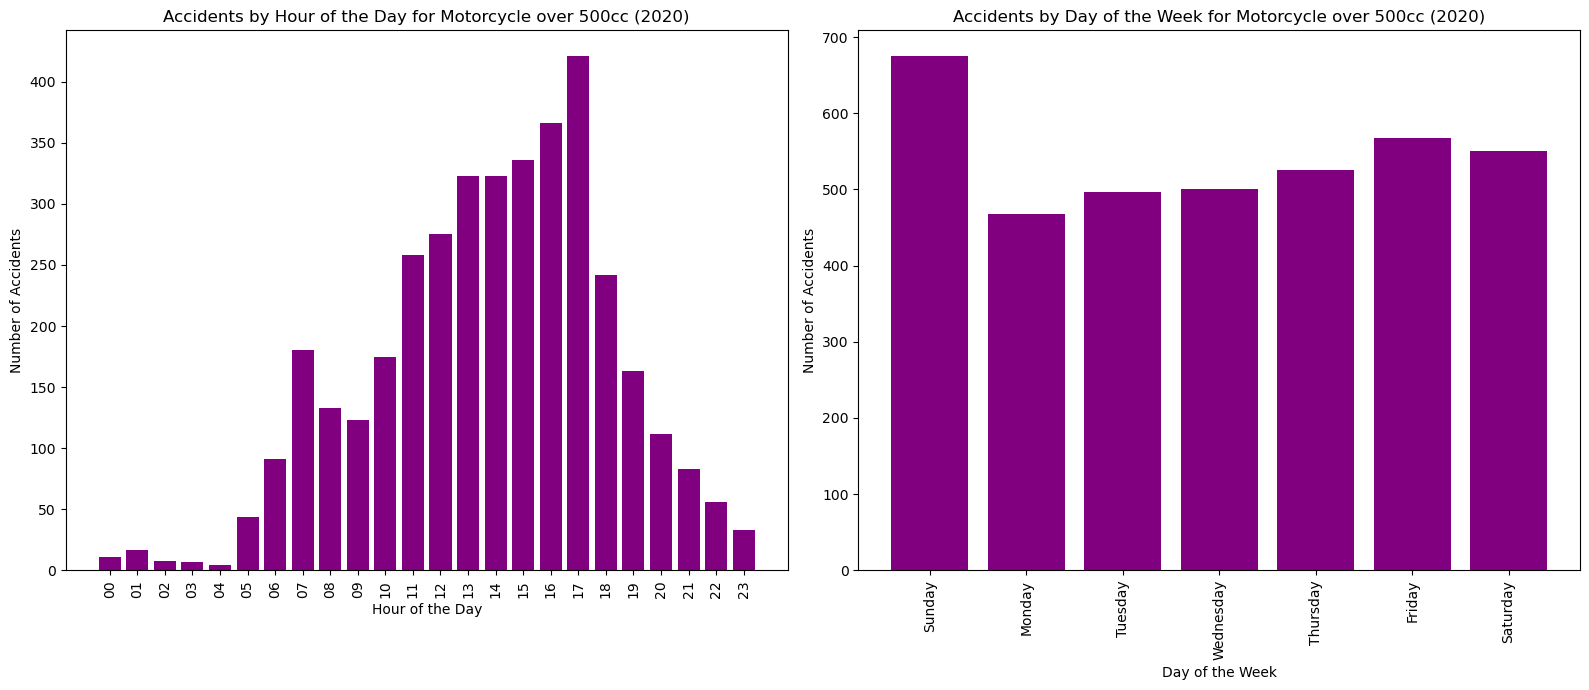

In [22]:
# Connect to the SQLite database
conn = sqlite3.connect("accident_data_v1.0.0_2023.db")

# Function to execute SQL query and get results as DataFrame
def execute_sql_query(query):
    return pd.read_sql_query(query, conn)

# Define the vehicle type of interest
motorcycle_type = (5, 'Motorcycle over 500cc')

# Define custom color for the motorcycle type
motorcycle_color = {
    5: 'purple'  # Color for 'Motorcycle over 500cc'
}

# Function to plot accidents by hour of the day for the specified motorcycle type
def plot_accidents_by_hour():
    type_id, type_name = motorcycle_type
    query = f"""
        SELECT strftime('%H', a.time) AS hour, COUNT(*) AS num_accidents
        FROM accident a
        JOIN vehicle v ON a.accident_index = v.accident_index
        WHERE a.accident_year = 2020 AND v.vehicle_type IN ({type_id})
        GROUP BY hour
        ORDER BY hour;
    """
    result = execute_sql_query(query)

    if result.empty:
        print(f"No accidents for {type_name} in the year 2020.")
    else:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
        
        # Plot for time
        ax_time = axes[0]
        ax_time.bar(result['hour'], result['num_accidents'], color=motorcycle_color[type_id])
        ax_time.set_xlabel('Hour of the Day')
        ax_time.set_ylabel('Number of Accidents')
        ax_time.set_title(f'Accidents by Hour of the Day for {type_name} (2020)')
        ax_time.set_xticks(range(24))
        ax_time.set_xticklabels(result['hour'], rotation=90)
        
        # Plot for day
        days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        query_day = f"""
            SELECT a.day_of_week, COUNT(*) AS num_accidents
            FROM accident a
            JOIN vehicle v ON a.accident_index = v.accident_index
            WHERE a.accident_year = 2020 AND v.vehicle_type IN ({type_id})
            GROUP BY a.day_of_week
            ORDER BY a.day_of_week;
        """
        result_day = execute_sql_query(query_day)

        if result_day.empty:
            print(f"No accidents for {type_name} in the year 2020.")
        else:
            ax_day = axes[1]
            ax_day.bar(days_of_week, result_day['num_accidents'], color=motorcycle_color[type_id])
            ax_day.set_xlabel('Day of the Week')
            ax_day.set_ylabel('Number of Accidents')
            ax_day.set_title(f'Accidents by Day of the Week for {type_name} (2020)')
            ax_day.set_xticks(range(7))
            ax_day.set_xticklabels(days_of_week, rotation=90)

        plt.tight_layout()
        plt.show()

# Execute and plot for the specified motorcycle type
plot_accidents_by_hour()

# Close the connection
conn.close()


### For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

Data for accidents involving pedestrians:
   hour  num_accidents
0    00            173
1    01            144
2    02             83
3    03             82
4    04             50
5    05             74
6    06            173
7    07            514
8    08           1060
9    09            607
10   10            644
11   11            725
12   12            809
13   13            833
14   14           1015
15   15           1672
16   16           1323
17   17           1274
18   18           1146
19   19            824
20   20            518
21   21            412
22   22            365
23   23            230


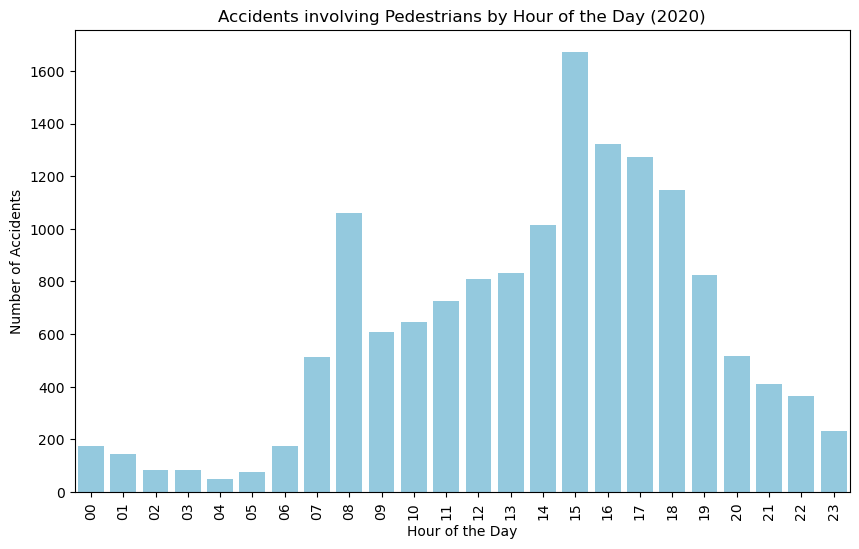

Data for accidents involving pedestrians:
   day_of_week  num_accidents
0            1           1242
1            2           2207
2            3           2267
3            4           2247
4            5           2366
5            6           2543
6            7           1878


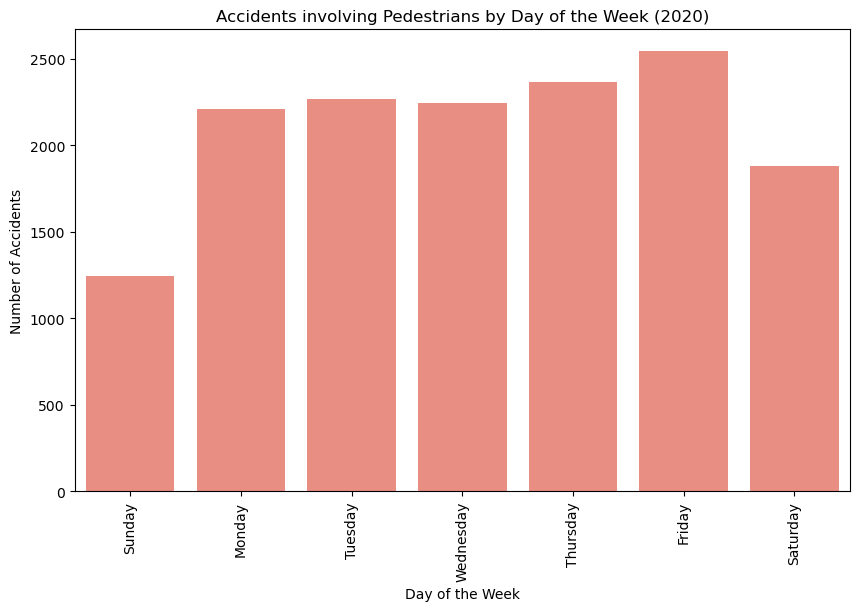

In [23]:
# Connect to the SQLite database
conn = sqlite3.connect("accident_data_v1.0.0_2023.db")

# Function to execute SQL query and get results as DataFrame
def execute_sql_query(query):
    return pd.read_sql_query(query, conn)

# Function to plot accidents involving pedestrians by hour of the day
def plot_pedestrian_accidents_by_hour():
    query = """
        SELECT strftime('%H', a.time) AS hour, COUNT(*) AS num_accidents
        FROM accident a
        JOIN casualty c ON a.accident_index = c.accident_index
        WHERE a.accident_year = 2020 AND c.casualty_class = 3
        GROUP BY hour
        ORDER BY hour;
    """
    result = execute_sql_query(query)
    
    if result.empty:
        print("No accidents involving pedestrians in the year 2020.")
    else:
        print("Data for accidents involving pedestrians:")
        print(result)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='hour', y='num_accidents', data=result, color='skyblue')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Number of Accidents')
        plt.title('Accidents involving Pedestrians by Hour of the Day (2020)')
        plt.xticks(rotation=90)
        plt.show()

# Function to plot accidents involving pedestrians by day of the week
def plot_pedestrian_accidents_by_day():
    query = """
        SELECT a.day_of_week, COUNT(*) AS num_accidents
        FROM accident a
        JOIN casualty c ON a.accident_index = c.accident_index
        WHERE a.accident_year = 2020 AND c.casualty_class = 3
        GROUP BY a.day_of_week
        ORDER BY a.day_of_week;
    """
    result = execute_sql_query(query)
    
    if result.empty:
        print("No accidents involving pedestrians in the year 2020.")
    else:
        print("Data for accidents involving pedestrians:")
        print(result)
        
        days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='day_of_week', y='num_accidents', data=result, color='salmon')
        plt.xlabel('Day of the Week')
        plt.ylabel('Number of Accidents')
        plt.title('Accidents involving Pedestrians by Day of the Week (2020)')
        plt.xticks(range(7), days_of_week, rotation=90)
        plt.show()

# Execute and plot accidents involving pedestrians by hour and day of the week
plot_pedestrian_accidents_by_hour()
plot_pedestrian_accidents_by_day()

# Close the connection
conn.close()


### cleaning relevant columns for apriori methods

#### For accident table

##### Handling police_force=99 is an outlier

In [24]:
# Count the number of rows with 'police_force' equal to 99
count_before = len(accidents_df[accidents_df['police_force']==99])
print(f"Number of occurrences of 99 before replacement: {count_before}")
count_before = len(accidents_df['police_force'])
print(f"Number of occurrences of all age_of_driver: {count_before}")

Number of occurrences of 99 before replacement: 3836
Number of occurrences of all age_of_driver: 91185


In [25]:
# Check the correlation between 'police_force' and 'first_road_number'
correlation_with_first_road_number = accidents_df['police_force'].corr(accidents_df['first_road_number'])

# Calculate the mode of 'police_force'
police_force_mode = accidents_df['police_force'].mode().iloc[0]

# If 'police_force' and 'first_road_number' have a positive correlation, replace the value 99 in 'police_force' with the mode value
if correlation_with_first_road_number > 0:
    accidents_df.loc[accidents_df['police_force'] == 99, 'police_force'] = police_force_mode


In [26]:
# Count the number of rows with 'police_force' equal to 99
count_before = len(accidents_df[accidents_df['police_force']==99])
print(f"Number of occurrences of 99 after replacement: {count_before}")

Number of occurrences of 99 after replacement: 0


#### Handling weather_conditions

In [27]:
# Count the number of rows with 'weather_conditions' equal to -1
count_before = len(accidents_df[accidents_df['weather_conditions']==-1])
print(f"Number of occurrences of -1 before replacement: {count_before}")
count_before = len(accidents_df['weather_conditions'])
print(f"Number of occurrences of all age_of_driver: {count_before}")

Number of occurrences of -1 before replacement: 1
Number of occurrences of all age_of_driver: 91185


In [28]:
# Replace -1 with 9 in the 'weather_conditions' column
accidents_df['weather_conditions'].replace(-1, 9, inplace=True)

C:\Users\juded\AppData\Local\Temp\ipykernel_10768\3641099417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_df['weather_conditions'].replace(-1, 9, inplace=True)


In [29]:
# Count the number of rows with 'weather_conditions' equal to -1
count_before = len(accidents_df[accidents_df['weather_conditions']==-1])
print(f"Number of occurrences of -1 after replacement: {count_before}")

Number of occurrences of -1 after replacement: 0


#### Handling speed_limit

In [30]:
# Count the number of rows with 'weather_conditions' equal to -1
count_before = len(accidents_df[accidents_df['speed_limit']==-1])
print(f"Number of occurrences of -1 before replacement: {count_before}")
count_before = len(accidents_df['speed_limit'])
print(f"Number of occurrences of all age_of_driver: {count_before}")

Number of occurrences of -1 before replacement: 12
Number of occurrences of all age_of_driver: 91185


In [31]:
# Drop rows where 'speed_limit' is -1
accidents_df.drop(accidents_df[accidents_df['speed_limit'] == -1].index, inplace=True)


#I dropped this column because 12 is insignificant compared to all the dataset rows


C:\Users\juded\AppData\Local\Temp\ipykernel_10768\4232894393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_df.drop(accidents_df[accidents_df['speed_limit'] == -1].index, inplace=True)


In [32]:
# Count the number of rows with 'weather_conditions' equal to -1
count_before = len(accidents_df[accidents_df['speed_limit']==-1])
print(f"Number of occurrences of -1 after replacement: {count_before}")

Number of occurrences of -1 after replacement: 0


#### Handling local_authority_district

In [33]:
# Count the number of rows with 'local_authority_district' equal to -1
count_before = len(accidents_df[accidents_df['local_authority_district']==-1])
print(f"Number of occurrences of -1 before replacement: {count_before}")
count_before = len(accidents_df['local_authority_district'])
print(f"Number of occurrences of all age_of_driver: {count_before}")

Number of occurrences of -1 before replacement: 985
Number of occurrences of all age_of_driver: 91173


In [34]:
# Get the mode of 'local_authority_district' for each 'first_road_number' group
mode_by_road_number = accidents_df.groupby('first_road_number')['local_authority_district'].apply(lambda x: x.mode().iloc[0])

# Replace the -1 values in 'local_authority_district' with the mode for each 'first_road_number' group
for road_number, mode_value in mode_by_road_number.items():
    accidents_df.loc[(accidents_df['local_authority_district'] == -1) & (accidents_df['first_road_number'] == road_number), 'local_authority_district'] = mode_value


In [35]:
# Count the number of rows with 'local_authority_district' equal to -1
count_before = len(accidents_df[accidents_df['local_authority_district']==-1])
print(f"Number of occurrences of -1 after replacement with correlation with first_road_number: {count_before}")

Number of occurrences of -1 after replacement with correlation with first_road_number: 195


In [36]:
# Get the mode of 'local_authority_district' for each 'first_road_class' group
mode_by_road_class = accidents_df.groupby('first_road_class')['local_authority_district'].apply(lambda x: x.mode().iloc[0])

# Replace the -1 values in 'local_authority_district' with the mode for each 'first_road_class' group
for road_class, mode_value in mode_by_road_class.items():
    accidents_df.loc[(accidents_df['local_authority_district'] == -1) & (accidents_df['first_road_class'] == road_class), 'local_authority_district'] = mode_value

    

In [37]:
# Count the number of rows with 'local_authority_district' equal to -1
count_before = len(accidents_df[accidents_df['local_authority_district']==-1])
print(f"Number of occurrences of -1 after replacement: {count_before}")

Number of occurrences of -1 after replacement: 0


#### handling junction_control

In [38]:
# Count the number of rows with 'local_authority_district' equal to -1
count_before = len(accidents_df[accidents_df['junction_control']==-1])
print(f"Number of occurrences of -1 before replacement: {count_before}")
count_before = len(accidents_df['junction_control'])
print(f"Number of occurrences of all age_of_driver: {count_before}")

Number of occurrences of -1 before replacement: 38285
Number of occurrences of all age_of_driver: 91173


In [39]:
# Replace -1 with 9
accidents_df['local_authority_district'].replace(-1, 9, inplace=True)

count_after = len(accidents_df[accidents_df['local_authority_district'] == -1])
print(f"Number of occurrences of -1 after replacement: {count_after}")


Number of occurrences of -1 after replacement: 0


C:\Users\juded\AppData\Local\Temp\ipykernel_10768\2773549438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_df['local_authority_district'].replace(-1, 9, inplace=True)


### For vehicle table

#### handling sex_of_driver

In [40]:
#### Vehicle	sex_of_driver	1	Male
#### Vehicle	sex_of_driver	2	Female
#### Vehicle	sex_of_driver	3	Not known


In [41]:
# Count the number of rows with 'sex_of_driver' equal to -1
count_before = len(vehicle_df[vehicle_df['sex_of_driver'] == -1])

# Replace -1 with 3 in the 'sex_of_driver' column
vehicle_df.loc[vehicle_df['sex_of_driver'] == -1, 'sex_of_driver'] = 3

# Count the number of rows with 'sex_of_driver' equal to -1 after replacement
count_after = len(vehicle_df[vehicle_df['sex_of_driver'] == -1])

print(f"Number of occurrences of -1 before replacement: {count_before}")
print(f"Number of occurrences of -1 after replacement: {count_after}")


Number of occurrences of -1 before replacement: 13
Number of occurrences of -1 after replacement: 0


#### handling age_of_driver

In [42]:
# Count the number of rows with 'age_of_driver' equal to -1
count_before = len(vehicle_df[vehicle_df['age_of_driver'] == -1])
print(f"Number of occurrences of -1 before replacement: {count_before}")
count_before = len(vehicle_df['age_of_driver'])
print(f"Number of occurrences of all age_of_driver: {count_before}")

Number of occurrences of -1 before replacement: 23344
Number of occurrences of all age_of_driver: 167375


In [43]:
mean_age = vehicle_df[vehicle_df['age_of_driver'] != -1]['age_of_driver'].mean()
vehicle_df.loc[vehicle_df['age_of_driver'] == -1, 'age_of_driver'] = mean_age

# Count the number of rows with 'age_of_driver' equal to -1 after replacement
count_before = len(vehicle_df[vehicle_df['age_of_driver'] == -1])
print(f"Number of occurrences of -1 after replacement: {count_before}")

Number of occurrences of -1 after replacement: 0


#### Handling age_of_vehicle

In [44]:
# Count the number of rows with 'age_of_vehicle' equal to -1
count_before = len(vehicle_df[vehicle_df['age_of_vehicle'] == -1])
print(f"Number of occurrences of -1 before replacement: {count_before}")
count_before = len(vehicle_df['age_of_vehicle'])
print(f"Number of occurrences of all age_of_driver: {count_before}")

Number of occurrences of -1 before replacement: 43072
Number of occurrences of all age_of_driver: 167375


In [45]:
mean_age = vehicle_df[vehicle_df['age_of_vehicle'] != -1]['age_of_vehicle'].mean()
vehicle_df.loc[vehicle_df['age_of_vehicle'] == -1, 'age_of_vehicle'] = mean_age

# Count the number of rows with 'age_of_driver' equal to -1 after replacement
count_before = len(vehicle_df[vehicle_df['age_of_vehicle'] == -1])
print(f"Number of occurrences of -1 after replacement: {count_before}")

Number of occurrences of -1 after replacement: 0


### For casualty table

#### Handling sex of casualty

In [46]:
#sex_of_casualty	1	Male
#sex_of_casualty	2	Female
#sex_of_casualty	9	unknown (self reported)


In [47]:
# Count the number of rows with 'sex_of_casualty' equal to -1
count_before = len(casualty_df[casualty_df['sex_of_casualty'] == -1])

# Replace -1 with 9 in the 'sex_of_casualty' column
casualty_df.loc[casualty_df['sex_of_casualty'] == -1, 'sex_of_casualty'] = 9

# Count the number of rows with 'sex_of_casualty' equal to -1 after replacement
count_after = len(casualty_df[casualty_df['sex_of_casualty'] == -1])

print(f"Number of occurrences of -1 before replacement: {count_before}")
print(f"Number of occurrences of -1 after replacement: {count_after}")


Number of occurrences of -1 before replacement: 756
Number of occurrences of -1 after replacement: 0


#### Handling age of casualty

In [48]:
# Calculate the mode of 'age_of_casualty' column
age_of_casualty_mode = casualty_df['age_of_casualty'].mode().iloc[0]
print(f"Number of occurrences of -1 before replacement: {count_before}")

# Replace -1 with the mode value
casualty_df['age_of_casualty'].replace(-1, age_of_casualty_mode, inplace=True)

# Count the number of rows with 'age_of_casualty' equal to -1 after replacement
count_after = len(casualty_df[casualty_df['age_of_casualty'] == -1])
print(f"Number of occurrences of -1 after replacement: {count_after}")


Number of occurrences of -1 before replacement: 756
Number of occurrences of -1 after replacement: 0


### Using the apriori algorithm, explore the impact of selected variables on accident severity.  

#### Using feature selection for accident severity for the apriori method

In [49]:
# Before this analysis, the tables will be merged

In [50]:
# Merge all three DataFrames
merged_df = accidents_df.merge(vehicle_df, on='accident_index', how='inner')
merged_df = merged_df.merge(casualty_df, on='accident_index', how='inner')
# Merge lsoa_df with merged_df based on a common column, such as 'accident_index'
final_merged_df = merged_df.merge(lsoa_df, left_on='lsoa_of_accident_location', right_on='lsoa01cd', how='inner')

In [51]:
# Drop duplicates from final_merged_df
final_merged_df = final_merged_df.drop_duplicates()

# Now final_merged_df contains the DataFrame with duplicates removed
final_merged_df

accident_index  accident_year_x accident_reference_x  \
0       2020010219808             2020            010219808   
1       2020010240428             2020            010240428   
2       2020010240428             2020            010240428   
3       2020010249713             2020            010249713   
4       2020010249713             2020            010249713   
...               ...              ...                  ...   
201924  202063D085620             2020            63D085620   
201925  202063D085620             2020            63D085620   
201926  202063D085620             2020            63D085620   
201927  202063D086520             2020            63D086520   
201928  202063D086520             2020            63D086520   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    521389.0                175144.0  -0.254001  51.462262   
1                    521357.0                174350.0  -0.254734  51.455133   
2                    521357.0                174350.0  -0.254734  51.455133   
3                    521564.0                174913.0  -0.251563  51.460148   
4                    521564.0                174913.0  -0.251563  51.460148   
...                       ...                     ...        ...        ...   
201924               295530.0                284080.0  -3.538477  52.444677   
201925               295530.0                284080.0  -3.538477  52.444677   
201926               295530.0                284080.0  -3.538477  52.444677   
201927               310980.0                291900.0  -3.313323  52.517700   
201928               310980.0                291900.0  -3.313323  52.517700   

        police_force  accident_severity  number_of_vehicles  ...  \
0                  1                  3                   1  ...   
1                  1                  2                   2  ...   
2                  1                  2                   2  ...   
3                  1                  3                   2  ...   
4                  1                  3                   2  ...   
...              ...                ...                 ...  ...   
201924            63                  2                   2  ...   
201925            63                  2                   2  ...   
201926            63                  2                   2  ...   
201927            63                  2                   2  ...   
201928            63                  2                   2  ...   

        casualty_type casualty_home_area_type  casualty_imd_decile objectid  \
0                   0                       1                    4     4576   
1                   1                       1                    8     4576   
2                   1                       1                    8     4576   
3                   1                       1                    4     4576   
4                   1                       1                    4     4576   
...               ...                     ...                  ...      ...   
201924              9                       1                    5    32948   
201925              9                       1                    5    32948   
201926              9                       1                    5    32948   
201927             90                       1                    9    32963   
201928             90                       1                    9    32963   

         lsoa01cd         lsoa01nm        lsoa01nmw   shape__area  \
0       E01004576  Wandsworth 013D  Wandsworth 013D  4.456251e+05   
1       E01004576  Wandsworth 013D  Wandsworth 013D  4.456251e+05   
2       E01004576  Wandsworth 013D  Wandsworth 013D  4.456251e+05   
3       E01004576  Wandsworth 013D  Wandsworth 013D  4.456251e+05   
4       E01004576  Wandsworth 013D  Wandsworth 013D  4.456251e+05   
...           ...              ...              ...           ...   
201924  W01000466       Powys 010C       Powys 010C 

In [52]:
final_merged_df = final_merged_df.dropna()

In [53]:
final_merged_df.accident_severity.unique()

array([3, 2, 1], dtype=int64)

In [54]:
# accident_severity	1	Fatal
# accident_severity	2	Serious
# accident_severity	3	Slight


In [55]:
y_label = final_merged_df['accident_severity']==1

In [56]:
y_label.value_counts()

False    198257
True       3672
Name: accident_severity, dtype: int64

In [57]:
accident_data_drop=final_merged_df

In [58]:
accident_data_bal, y_bal = RandomUnderSampler().fit_resample(accident_data_drop, y_label)
#accident_data_bal, y_bal = RandomUnderSampler().fit_resample(accident_data_drop, y_label)

In [59]:
y_bal

0       False
1       False
2       False
3       False
4       False
        ...  
7339     True
7340     True
7341     True
7342     True
7343     True
Name: accident_severity, Length: 7344, dtype: bool

In [60]:
accident_data_bal = accident_data_bal.drop(['accident_severity', 'did_police_officer_attend_scene_of_accident','casualty_severity'], axis = 1)

In [61]:
accident_data_bal = accident_data_bal.select_dtypes([np.number])

In [62]:
#accident_data_bal.isna().sum()

In [63]:
accident_data_bal=accident_data_bal.dropna()

In [64]:
accident_data_bal

accident_year_x  location_easting_osgr  location_northing_osgr  \
0                2020               446102.0                519921.0   
1                2020               372155.0                378367.0   
2                2020               397879.0                288312.0   
3                2020               547615.0                122502.0   
4                2020               377599.0                395531.0   
...               ...                    ...                     ...   
7339             2020               322000.0                243260.0   
7340             2020               322000.0                243260.0   
7341             2020               322000.0                243260.0   
7342             2020               322000.0                243260.0   
7343             2020               322000.0                243260.0   

      longitude   latitude  police_force  number_of_vehicles  \
0     -1.288408  54.572425            17                   2   
1     -2.419278  53.301531             7                   2   
2     -2.032662  52.492730            20                   2   
3      0.101609  50.983003            47                   3   
4     -2.338816  53.456068             6                   3   
...         ...        ...           ...                 ...   
7339  -3.139679  52.082186            63                   6   
7340  -3.139679  52.082186            63                   6   
7341  -3.139679  52.082186            63                   6   
7342  -3.139679  52.082186            63                   6   
7343  -3.139679  52.082186            63                   6   

      number_of_casualties  day_of_week  local_authority_district  ...  \
0                        1            6                       245  ...   
1                        2            4                       130  ...   
2                        1            5                       305  ...   
3                        1            3                       556  ...   
4                        1            4                       112  ...   
...                    ...          ...                       ...  ...   
7339                     1            4                       753  ...   
7340                     1            4                       753  ...   
7341                     1            4                       753  ...   
7342                     1            4                       753  ...   
7343                     1            4                       753  ...   

      pedestrian_movement  car_passenger  bus_or_coach_passenger  \
0                       0              0                       0   
1                       0              0                       0   
2                       0              0                       0   
3                       0              0                       0   
4                       0              1                       0   
...                   ...            ...                     ...   
7339                    0              0                       0   
7340                    0              0                       0   
7341                    0              0                       0   
7342                    0              0                       0   
7343                    0              0                       0   

      pedestrian_road_maintenance_worker  casualty_type  \
0                                      0              9   
1                                      0              9   
2                                      0              9   
3                                      0              9   
4                                      0              9   
...                                  ...            ...   
7339                                   0              9   
7340                                   0              9   
7341                                   0              9   
7342                                   0              9   
7343             

In [65]:
#accident_data_bal.info()

In [66]:
selector = SelectKBest(f_classif, k = 6)
selector.fit(accident_data_bal, y_bal)

C:\Users\juded\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 0 29 54] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\juded\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=6)

In [67]:
mask = selector.get_support()
names = selector.feature_names_in_[mask]
scores = selector.scores_[mask]

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

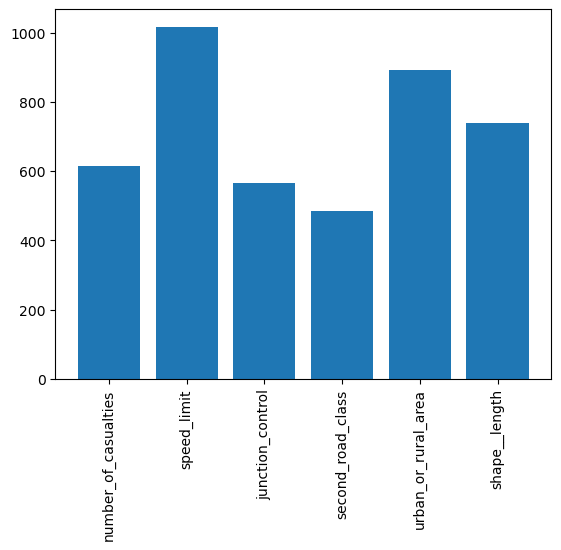

In [68]:
plt.bar(names, scores)
plt.xticks(rotation = 'vertical')

In [69]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [70]:
final_merged_df.columns

Index(['accident_index', 'accident_year_x', 'accident_reference_x',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location', 'hour', 'vehicle_index',
       'accident_year_y', 'accident_reference_y', 'vehicle_reference

In [71]:
# Features selected for Apriori
a_severity = pd.get_dummies(final_merged_df.accident_severity, prefix = 'a_severity')
speed = pd.get_dummies(final_merged_df.speed_limit, prefix = 'speed')
w_conditions = pd.get_dummies(final_merged_df.weather_conditions, prefix = 'weather')
urban_or_rural_area = pd.get_dummies(final_merged_df.urban_or_rural_area, prefix = 'urban_or_rural_area')
junction_control = pd.get_dummies(final_merged_df.junction_control, prefix = 'junction_control')
shape__length = pd.get_dummies(final_merged_df.shape__length, prefix = 'shape__length')
number_of_casualties = pd.get_dummies(final_merged_df.number_of_casualties, prefix = 'number_of_casualties')
#local_authority_district = pd.get_dummies(final_merged_df.local_authority_district, prefix = 'local_authority_district')
#second_road_class = pd.get_dummies(final_merged_df.second_road_class, prefix = 'second_road_class')



In [72]:
accident_onehot = pd.concat([a_severity, speed, w_conditions,urban_or_rural_area,junction_control,number_of_casualties,shape__length], axis = 1)
accident_onehot.dropna(axis=0, inplace=True)

#accident_onehot

In [73]:
# Convert non-boolean values to boolean based on a threshold
threshold = 0  # Set your threshold here
accident_onehot_boolean = accident_onehot > threshold


In [74]:
'''
choose support of 0.01 because that's the minimum ratio for accident severity 
compared to the whole severity types
'''
frequent_itemsets = apriori(accident_onehot_boolean, min_support=0.01, use_colnames=True)
# Continue with your further analysis using frequent_itemsets


In [75]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
#rules

In [76]:
# Filter rules where 'a_severity_1' is in the antecedents
filtered_rules = rules[rules['consequents'].apply(lambda x: 'a_severity_1' in x)]

# Print the filtered rules
filtered_rules


antecedents  \
1                           (weather_1)   
2               (urban_or_rural_area_2)   
5                 (junction_control_-1)   
161  (urban_or_rural_area_2, weather_1)   
163             (urban_or_rural_area_2)   
165                         (weather_1)   

                               consequents  antecedent support  \
1                           (a_severity_1)            0.781681   
2                           (a_severity_1)            0.360597   
5                           (a_severity_1)            0.424724   
161                         (a_severity_1)            0.280925   
163              (a_severity_1, weather_1)            0.360597   
165  (urban_or_rural_area_2, a_severity_1)            0.781681   

     consequent support   support  confidence      lift  leverage  conviction  \
1              0.018185  0.014456    0.018493  1.016956  0.000241    1.000314   
2              0.018185  0.012395    0.034375  1.890323  0.005838    1.016767   
5              0.018185  0.012608    0.029686  1.632486  0.004885    1.011853   
161            0.018185  0.010083    0.035891  1.973713  0.004974    1.018366   
163            0.014456  0.010083    0.027961  1.934290  0.004870    1.013894   
165            0.012395  0.010083    0.012899  1.040609  0.000393    1.000510   

     zhangs_metric  
1         0.076370  
2         0.736609  
5         0.673480  
161       0.686077  
163       0.755415  
165       0.178748

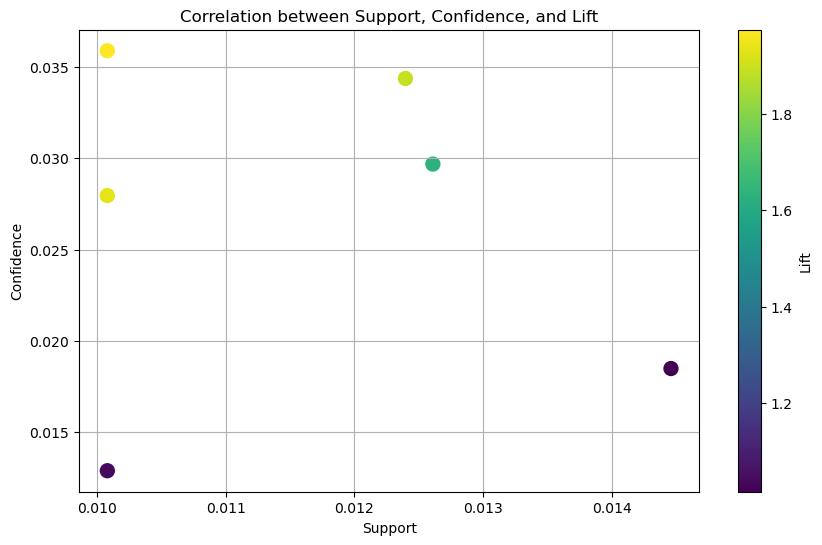

In [77]:
# Filtered association rules
filtered_rules = filtered_rules[['support', 'confidence', 'lift']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_rules['support'], filtered_rules['confidence'], c=filtered_rules['lift'], cmap='viridis', s=100)
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Correlation between Support, Confidence, and Lift')
plt.grid(True)
plt.show()


In [78]:
# Filter rules where 'a_severity_1' is in the antecedents
filtered_rules = rules[rules['consequents'].apply(lambda x: 'a_severity_2' in x)]

# Sort the filtered rules by 'lift' in descending order
filtered_rules_sorted = filtered_rules.sort_values(by='lift', ascending=False)

filtered_rules_sorted


antecedents  \
1493                                    (speed_60)   
1517  (urban_or_rural_area_2, junction_control_-1)   
3993                         (speed_60, weather_1)   
3990                (speed_60, junction_control_4)   
3970                                    (speed_60)   
...                                            ...   
285                                    (weather_1)   
174                                     (speed_20)   
1641                                   (weather_1)   
1612                         (junction_control_-1)   
1627                                   (weather_1)   

                                            consequents  antecedent support  \
1493  (number_of_casualties_2, a_severity_2, urban_o...            0.133656   
1517                           (a_severity_2, speed_70)            0.218671   
3993  (urban_or_rural_area_2, a_severity_2, junction...            0.105126   
3990   (urban_or_rural_area_2, a_severity_2, weather_1)            0.045917   
3970  (urban_or_rural_area_2, junction_control_-1, a...            0.133656   
...                                                 ...                 ...   
285              (number_of_casualties_3, a_severity_2)            0.781681   
174              (a_severity_2, number_of_casualties_1)            0.101367   
1641  (number_of_casualties_3, a_severity_2, junctio...            0.781681   
1612  (a_severity_2, number_of_casualties_1, weather_1)            0.424724   
1627  (a_severity_2, number_of_casualties_2, junctio...            0.781681   

      consequent support   support  confidence      lift  leverage  \
1493            0.024226  0.011321    0.084701  3.496244  0.008083   
1517            0.015882  0.011479    0.052496  3.305396  0.008006   
3993            0.031328  0.010885    0.103542  3.305127  0.007592   
3990            0.071946  0.010885    0.237058  3.294937  0.007581   
3970            0.044159  0.019314    0.144503  3.272335  0.013412   
...                  ...       ...         ...       ...       ...   
285             0.023696  0.018586    0.023777  1.003384  0.000063   
174             0.104799  0.010657    0.105135  1.003200  0.000034   
1641            0.012985  0.010162    0.013000  1.001187  0.000012   
1612            0.085297  0.036255    0.085362  1.000760  0.000028   
1627            0.022860  0.017878    0.022871  1.000488  0.000009   

      conviction  zhangs_metric  
1493    1.066071       0.824128  
1517    1.038642       0.892664  
3993    1.080556       0.779372  
3990    1.216414       0.730025  
3970    1.117294       0.801538  
...          ...            ...  
285     1.000082       0.015449  
174     1.000375       0.003550  
1641    1.000016       0.005431  
1612    1.000071       0.001321  
1627    1.000011       0.002236  

[534 rows x 10 columns]

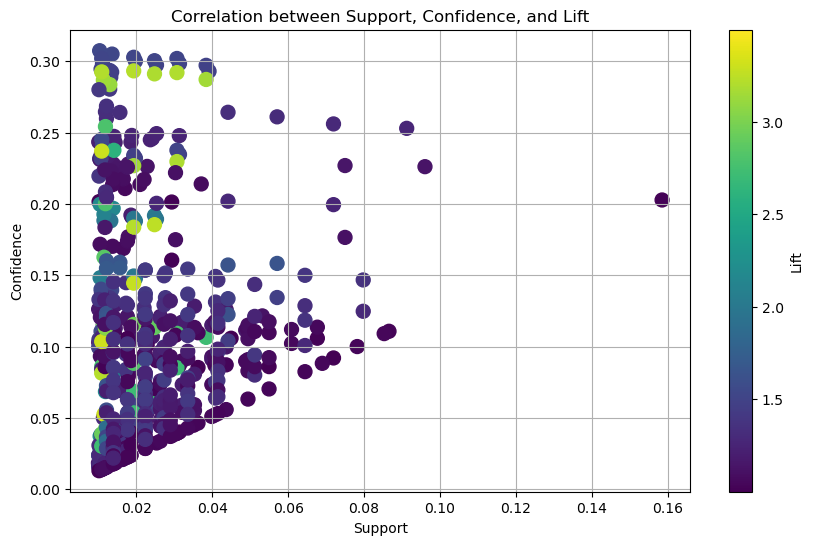

In [79]:
# Filtered association rules
filtered_rules = filtered_rules[['support', 'confidence', 'lift']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_rules['support'], filtered_rules['confidence'], c=filtered_rules['lift'], cmap='viridis', s=100)
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Correlation between Support, Confidence, and Lift')
plt.grid(True)
plt.show()


In [80]:
# Filter rules where 'a_severity_1' is in the antecedents
filtered_rules = rules[rules['consequents'].apply(lambda x: 'a_severity_3' in x)]

# Sort the filtered rules by 'lift' in descending order
filtered_rules_sorted = filtered_rules.sort_values(by='lift', ascending=False)

filtered_rules_sorted


antecedents  \
5343             (speed_70, number_of_casualties_1)   
6974  (speed_70, weather_1, number_of_casualties_1)   
6986             (speed_70, number_of_casualties_1)   
5376                                     (speed_70)   
5371             (number_of_casualties_2, speed_70)   
...                                             ...   
2690   (number_of_casualties_1, junction_control_4)   
526             (number_of_casualties_2, weather_1)   
2698            (number_of_casualties_2, weather_2)   
6253                                    (weather_1)   
2163                                    (weather_1)   

                                            consequents  antecedent support  \
5343  (urban_or_rural_area_2, junction_control_-1, a...            0.027435   
6974  (urban_or_rural_area_2, junction_control_-1, a...            0.020096   
6986  (urban_or_rural_area_2, junction_control_-1, w...            0.027435   
5376  (urban_or_rural_area_2, number_of_casualties_2...            0.070569   
5371  (urban_or_rural_area_2, junction_control_-1, a...            0.019393   
...                                                 ...                 ...   
2690                          (weather_2, a_severity_3)            0.275206   
526                                      (a_severity_3)            0.176339   
2698                 (junction_control_4, a_severity_3)            0.030050   
6253  (speed_20, a_severity_3, number_of_casualties_...            0.781681   
2163    (urban_or_rural_area_2, speed_40, a_severity_3)            0.781681   

      consequent support   support  confidence      lift  leverage  \
5343            0.151840  0.015931    0.580686  3.824315  0.011766   
6974            0.151840  0.011459    0.570232  3.755465  0.008408   
6986            0.115085  0.011459    0.417690  3.629400  0.008302   
5376            0.041569  0.010598    0.150175  3.612673  0.007664   
5371            0.151840  0.010598    0.546476  3.599013  0.007653   
...                  ...       ...         ...       ...       ...   
2690            0.100243  0.027599    0.100284  1.000411  0.000011   
526             0.782676  0.138058    0.782914  1.000304  0.000042   
2698            0.348315  0.010469    0.348385  1.000199  0.000002   
6253            0.017224  0.013465    0.017226  1.000116  0.000002   
2163            0.034532  0.026995    0.034534  1.000062  0.000002   

      conviction  zhangs_metric  
5343    2.022731       0.759348  
6974    1.973527       0.748769  
6986    1.519662       0.744909  
5376    1.127799       0.778107  
5371    1.870153       0.736428  
...          ...            ...  
2690    1.000046       0.000566  
526     1.001096       0.000369  
2698    1.000107       0.000206  
6253    1.000002       0.000530  
2163    1.000002       0.000286  

[1912 rows x 10 columns]

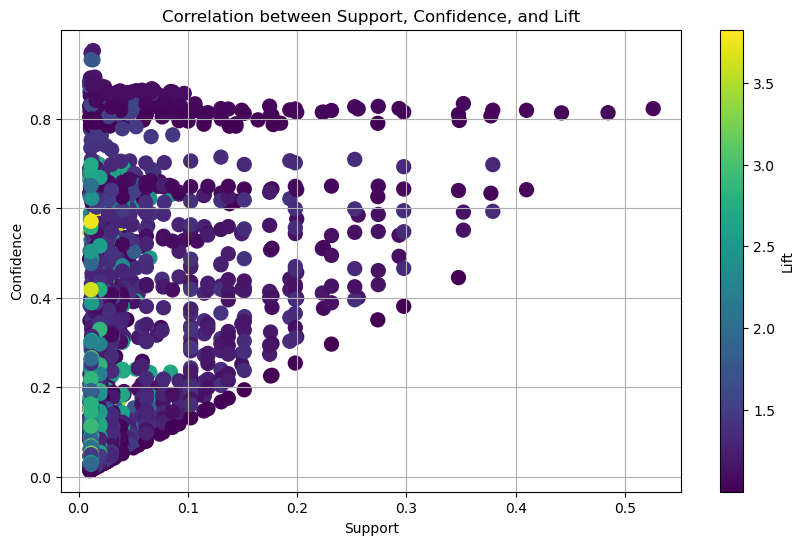

In [81]:
# Filtered association rules
filtered_rules = filtered_rules[['support', 'confidence', 'lift']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_rules['support'], filtered_rules['confidence'], c=filtered_rules['lift'], cmap='viridis', s=100)
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Correlation between Support, Confidence, and Lift')
plt.grid(True)
plt.show()


In [82]:
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules

# # Features selected for Apriori
# a_severity = pd.get_dummies(accidents_df.accident_severity, prefix='a_severity')

# # Other columns that should not generate dummies
# other_columns = [
#     'speed_limit', 'weather_conditions', 'urban_or_rural_area',
#     'junction_control', 'police_force', 'number_of_casualties',
#     'local_authority_district', 'second_road_class'
# ]

# # Create a DataFrame without generating dummies for the other columns
# accident_onehot = pd.concat([a_severity] + [accidents_df[other_col] for other_col in other_columns], axis=1)

# # Replace non-zero values with 1 to make it binary (presence or absence)
# accident_onehot = accident_onehot.applymap(lambda x: 1 if x != 0 else 0)

# # Drop rows with any missing values
# accident_onehot.dropna(axis=0, inplace=True)

# frequent_itemsets = apriori(accident_onehot, min_support=0.01, use_colnames=True)

# rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)


### Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region? 

In [83]:
conn = sqlite3.connect("accident_data_v1.0.0_2023.db")
# Execute the SQL query to retrieve the required data from the database where police_force = 16
lsoa_query = """
SELECT a.*, l.*
FROM accident a
JOIN lsoa l ON a.lsoa_of_accident_location = l.lsoa01cd
WHERE (a.police_force = 16)
   AND a.accident_year = 2020
"""

# Assuming you have a connection 'conn' to your database
lsoa_result = pd.read_sql_query(lsoa_query, conn)

# Now, lsoa_result DataFrame will contain 'accident_index', 'latitude', and 'longitude' columns for clustering


In [84]:
lsoa_result

accident_index  accident_year accident_reference  location_easting_osgr  \
0     2020160914930           2020          160914930               506050.0   
1     2020160915008           2020          160915008               497660.0   
2     2020160915028           2020          160915028               510449.0   
3     2020160915041           2020          160915041               526236.0   
4     2020160915047           2020          160915047               510322.0   
...             ...            ...                ...                    ...   
1658  2020161014491           2020          161014491               489433.0   
1659  2020161014528           2020          161014528               503756.0   
1660  2020161014544           2020          161014544               511525.0   
1661  2020161014546           2020          161014546               485978.0   
1662  2020161014949           2020          161014949               509443.0   

      location_northing_osgr  longitude   latitude  police_force  \
0                   428813.0  -0.393424  53.744936            16   
1                   402806.0  -0.528743  53.512895            16   
2                   434112.0  -0.324858  53.791630            16   
3                   410340.0  -0.095008  53.574501            16   
4                   431457.0  -0.327733  53.767805            16   
...                      ...        ...        ...           ...   
1658                408637.0  -0.651104  53.566753            16   
1659                439285.0  -0.424674  53.839482            16   
1660                433149.0  -0.308880  53.782750            16   
1661                408912.0  -0.703181  53.569801            16   
1662                428632.0  -0.342063  53.742609            16   

      accident_severity  number_of_vehicles  ...  \
0                     3                   2  ...   
1                     3                   1  ...   
2                     2                   1  ...   
3                     3                   1  ...   
4                     3                   1  ...   
...                 ...                 ...  ...   
1658                  3                   2  ...   
1659                  3                   2  ...   
1660                  3                   1  ...   
1661                  3                   2  ...   
1662                  3                   2  ...   

      did_police_officer_attend_scene_of_accident trunk_road_flag  \
0                                               1               2   
1                                               1               2   
2                                               1               2   
3                                               1               2   
4                                               1               2   
...                                           ...             ...   
1658                                            2               2   
1659                                            2               2   
1660                                            2               2   
1661                                            2               1   
1662                                            2               2   

      lsoa_of_accident_location objectid   lsoa01cd  \
0                     E01012777    12777  E01012777   
1                     E01013325    13325  E01013325   
2                     E01012788    12788  E01012788   
3                     E01013220    13220  E01013220   
4                     E01012817    12817  E01012817   
...                         ...      ...        ...   
1658                  E01013239    13239  E01013239   
1659                  E01013041    13041  E01013041   
1660                  E01012907    12907  E01012907   
1661                  E01013286    13286  E01013286   
1662                  E01012854    12854  E01012854   

                           lsoa01nm                      lsoa01nmw  \
0           Kingston upon Hull 028E       

In [85]:
accidents_df_coord = lsoa_result[['longitude', 'latitude']]
accidents_df_coord

longitude   latitude
0     -0.393424  53.744936
1     -0.528743  53.512895
2     -0.324858  53.791630
3     -0.095008  53.574501
4     -0.327733  53.767805
...         ...        ...
1658  -0.651104  53.566753
1659  -0.424674  53.839482
1660  -0.308880  53.782750
1661  -0.703181  53.569801
1662  -0.342063  53.742609

[1663 rows x 2 columns]

In [86]:
#accidents_df_coord.dropna(inplace=True)

In [87]:
X =  pd.DataFrame(accidents_df_coord).to_numpy()

In [88]:
scaler = StandardScaler()

In [89]:
X_scaler = scaler.fit_transform(accidents_df_coord)


In [90]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
kmeans.fit(X)

C:\Users\juded\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


KMeans(n_clusters=5, n_init=10, random_state=0)

In [91]:
labels = kmeans.fit_predict(X)
labels

C:\Users\juded\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


array([4, 3, 4, ..., 4, 3, 4])

In [92]:
sum_squared_errors = []

for num_clusters in range(1,21):
    kmeans_model = KMeans(n_clusters = num_clusters, n_init = 10)
    kmeans_model.fit(X_scaler)
    sum_squared_errors.append(kmeans_model.inertia_)

C:\Users\juded\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\juded\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\juded\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\juded\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\juded\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\juded\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


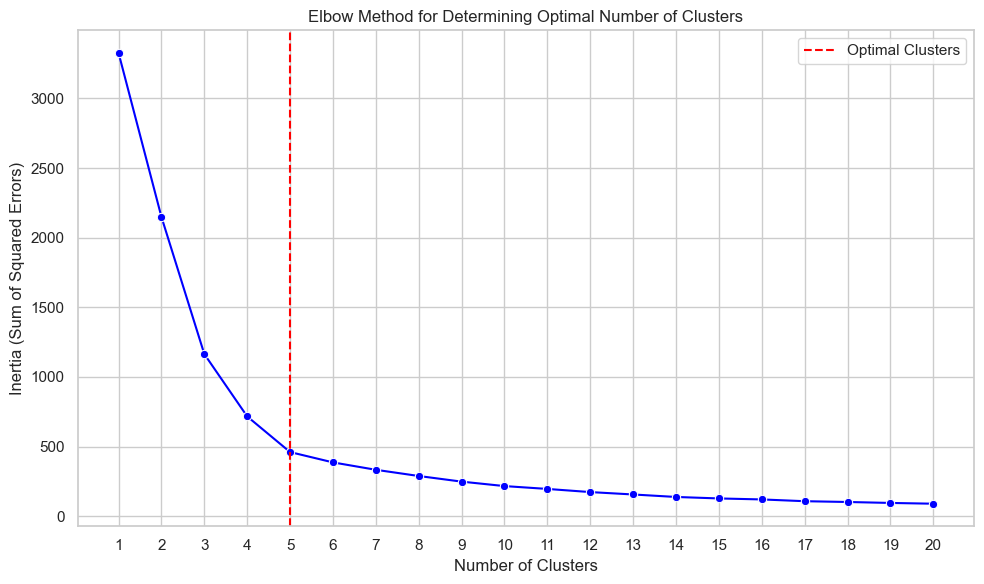

In [93]:
# Create a DataFrame with the number of clusters and their corresponding SSE
cluster_data = pd.DataFrame({'Num_Clusters': range(1, 21), 'SSE': sum_squared_errors})

# Set the style for the plot using Seaborn's built-in styles (optional but improves aesthetics)
sns.set(style="whitegrid")

# Create a plot to visualize the elbow method
plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster_data, x='Num_Clusters', y='SSE', marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xticks(range(1, 21))  # Set the x-axis ticks from 1 to 20
plt.axvline(x=5, color='red', linestyle='--', label='Optimal Clusters')  # Example: Mark the optimal number of clusters
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


C:\Users\juded\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\juded\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\juded\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


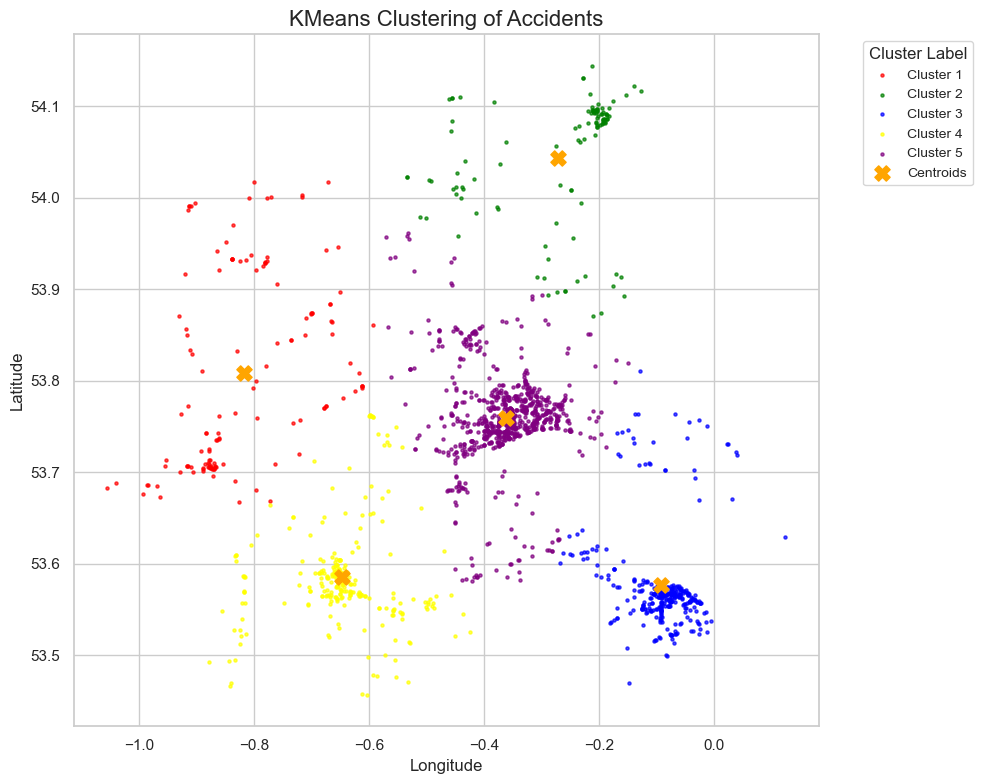

In [94]:

# Fit the KMeans model
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
labels = kmeans.fit_predict(accidents_df_coord)
centroids = kmeans.cluster_centers_

# Set the style for the plot (optional but improves aesthetics)
sns.set(style="whitegrid")

# Create the scatter plot to visualize the clusters and centroids
plt.figure(figsize=(10, 8))

# Define colors for the clusters
cluster_colors = ['red', 'green', 'blue', 'yellow', 'purple']

# Plot data points with different colors for each cluster
for i, color in enumerate(cluster_colors):
    cluster_data = accidents_df_coord[labels == i]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], s=5, color=color, alpha=0.7, label=f'Cluster {i+1}')

# Plot centroids with orange X markers
plt.scatter(centroids[:, 0], centroids[:, 1], color='orange', marker='X', s=120, label='Centroids')

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('KMeans Clustering of Accidents', fontsize=16)
plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


In [95]:


# Fit the KMeans model
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
labels = kmeans.fit_predict(accidents_df_coord)
centroids = kmeans.cluster_centers_

# Create a map centered on the median of the data points
median_lat = accidents_df_coord['latitude'].median()
median_long = accidents_df_coord['longitude'].median()
map_center = [median_lat, median_long]
map_clusters = folium.Map(location=map_center, zoom_start=10)

# Define colors for the clusters
cluster_colors = ['red', 'green', 'blue', 'yellow', 'purple']

# Add data points to the map with different colors for each cluster
for i, color in enumerate(cluster_colors):
    cluster_data = accidents_df_coord[labels == i]
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=1,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f'Cluster {i+1}',
        ).add_to(map_clusters)

# Add centroids to the map with orange markers
for centroid in centroids:
    folium.Marker(
        location=[centroid[1], centroid[0]],
        icon=folium.Icon(color='orange', icon='star'),
        popup='Centroid',
    ).add_to(map_clusters)

# Save the map as an HTML file or display it
#map_clusters.save('kmeans_clustering_map.html')
map_clusters

C:\Users\juded\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


C:\Users\juded\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\juded\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Cluster 1 - Number of Accidents: 134, Cluster Center: [-0.8177225  53.80799228]
Cluster 2 - Number of Accidents: 110, Cluster Center: [-0.2715766 54.0433033]
Cluster 3 - Number of Accidents: 333, Cluster Center: [-0.09147249 53.57621063]
Cluster 4 - Number of Accidents: 255, Cluster Center: [-0.64717868 53.58547258]
Cluster 5 - Number of Accidents: 831, Cluster Center: [-0.36222849 53.75941016]


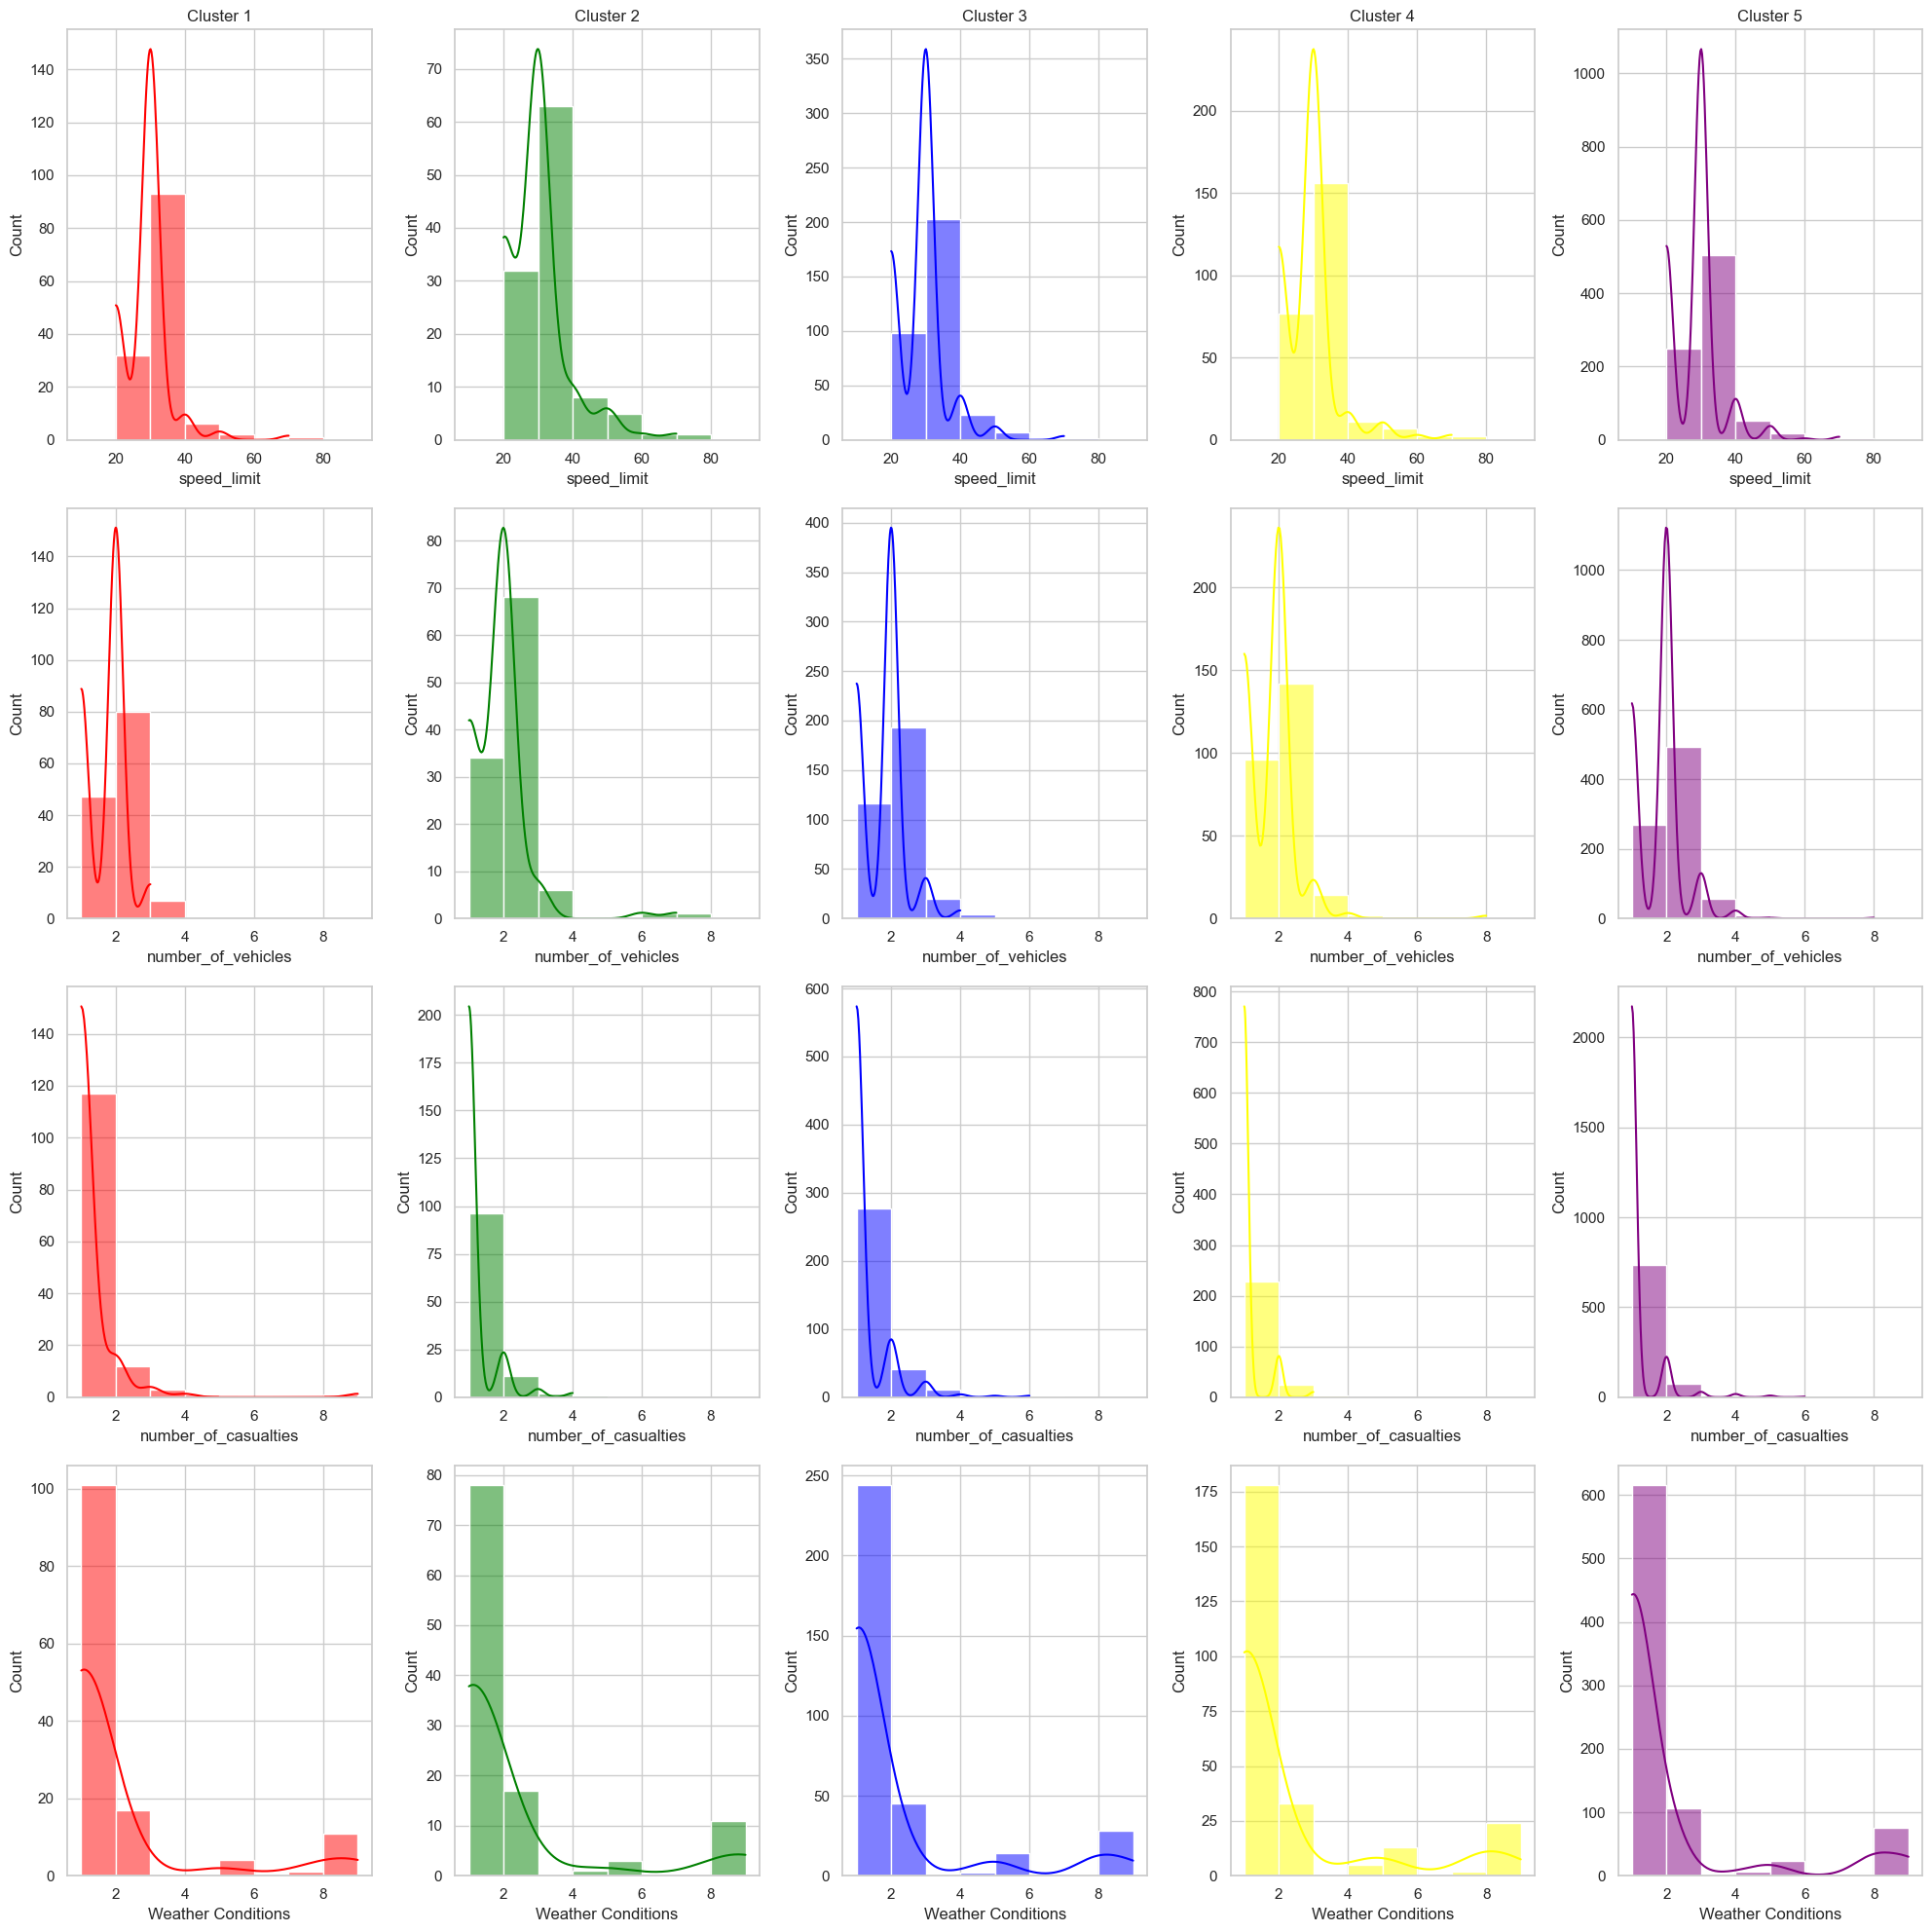

In [96]:
# ... (previous code)

# Define the selected columns
selected_columns = ['speed_limit', 'number_of_vehicles', 'number_of_casualties', 'weather_conditions']

# Define cluster colors
cluster_colors = ['red', 'green', 'blue', 'yellow', 'purple']

# Set the style for the plots
sns.set(style="whitegrid")

# Create subplots for each selected column
fig, axs = plt.subplots(len(selected_columns), 5, figsize=(20, 20))

# Analyze the clusters
for i in range(5):
    cluster_data = accidents_df_coord[labels == i]
    cluster_center = centroids[i]
    
    print(f"Cluster {i+1} - Number of Accidents: {len(cluster_data)}, Cluster Center: {cluster_center}")
    
    # Get accident indices and additional variables for each cluster
    cluster_indices = cluster_data.index
    cluster_additional_data = accidents_df.loc[cluster_indices, selected_columns]
    
    for j, column in enumerate(selected_columns):
        bins = range(10, 100, 10) if column == 'speed_limit' else range(1, 10)
        sns.histplot(data=cluster_additional_data, x=column, bins=bins, kde=True, color=cluster_colors[i], ax=axs[j, i])
        
        # Add titles to the first row
        if j == 0:
            axs[j, i].set_title(f'Cluster {i+1}')
            
        # Add y-label to the last row
        if j == len(selected_columns) - 1:
            axs[j, i].set_xlabel(column.replace("_", " ").title())
        
plt.tight_layout()
plt.show()


In [97]:
#

### DBSCAN

C:\Users\juded\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\juded\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


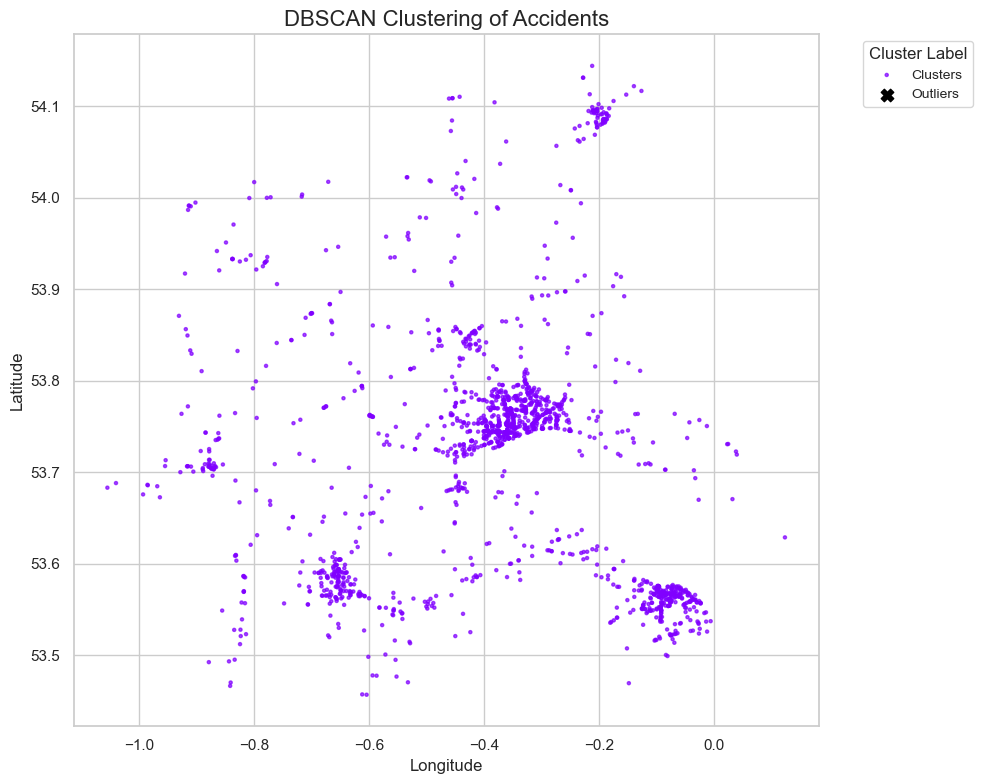

In [98]:
# Perform DBSCAN clustering
dbscan_opt = DBSCAN(eps=0.5, min_samples=6)
labels = dbscan_opt.fit_predict(accidents_df_coord)

# Set the style for the plot (optional but improves aesthetics)
sns.set(style="whitegrid")

# Create the scatter plot to visualize the clusters and outliers
plt.figure(figsize=(10, 8))

# Plot data points with different colors for each cluster (outliers will have label -1)
plt.scatter(accidents_df_coord['longitude'], accidents_df_coord['latitude'], c=labels, s=5, cmap='rainbow', label='Clusters', alpha=0.7)

# Plot outliers with black X markers
plt.scatter(accidents_df_coord[labels == -1]['longitude'], accidents_df_coord[labels == -1]['latitude'], color='black', marker='X', s=80, label='Outliers')

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('DBSCAN Clustering of Accidents', fontsize=16)
plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


In [99]:
# Perform DBSCAN clustering
dbscan_opt = DBSCAN(eps=0.5, min_samples=6)
labels = dbscan_opt.fit_predict(accidents_df_coord)

# Create a map centered on the median of the data points
median_lat = accidents_df_coord['latitude'].median()
median_long = accidents_df_coord['longitude'].median()
map_center = [median_lat, median_long]
map_clusters = folium.Map(location=map_center, zoom_start=10)

# Define colors for the clusters
cluster_colors = ['red', 'green', 'blue', 'yellow', 'purple', 'black']  # Add black for outliers

# Add data points to the map with different colors for each cluster (outliers will have label -1)
for label in set(labels):
    if label == -1:
        cluster_data = accidents_df_coord[labels == label]
        for _, row in cluster_data.iterrows():
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                icon=folium.Icon(color='black', icon='times'),
                popup='Outlier',
            ).add_to(map_clusters)
    else:
        cluster_data = accidents_df_coord[labels == label]
        for _, row in cluster_data.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=1,
                color=cluster_colors[label % len(cluster_colors)],
                fill=True,
                fill_color=cluster_colors[label % len(cluster_colors)],
                fill_opacity=0.7,
                popup=f'Cluster {label}',
            ).add_to(map_clusters)

# Save the map as an HTML file or display it
#map_clusters.save('dbscan_clustering_map.html')
map_clusters

### CLUSTERING

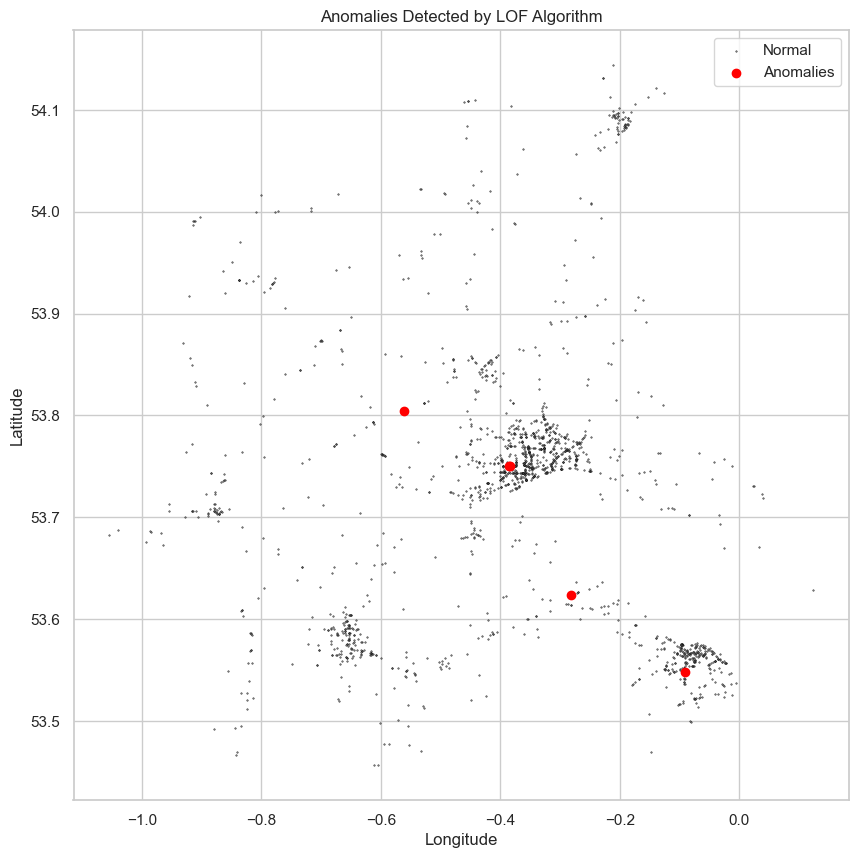

In [100]:


# LOF model
model = LocalOutlierFactor(n_neighbors=1, contamination=0.0025)
y_pred = model.fit_predict(X)
LOF_pred = np.where(y_pred == -1, 1, 0)
LOF_anomalies = X[LOF_pred == 1]

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c='white', s=0.2, edgecolors='k', label='Normal')
plt.scatter(LOF_anomalies[:, 0], LOF_anomalies[:, 1], c='red', label='Anomalies')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Anomalies Detected by LOF Algorithm')
plt.legend()
plt.show()


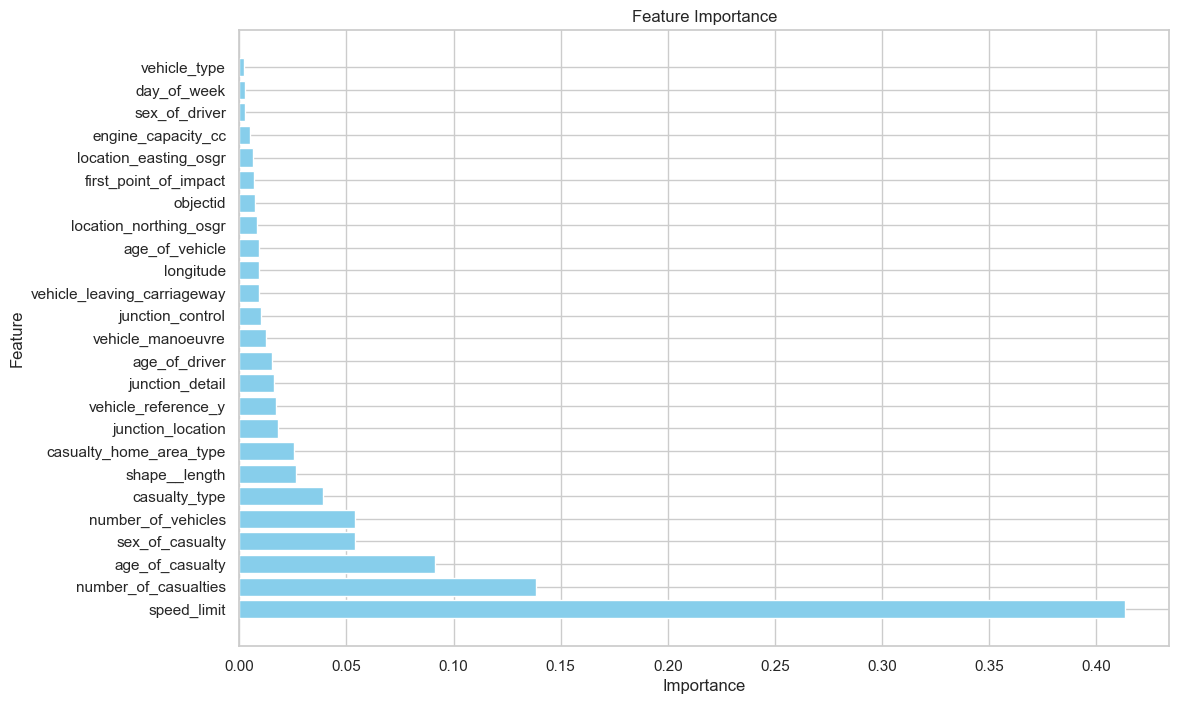

In [101]:
# Create a dictionary from the provided data
data = {
    'Feature': ['speed_limit', 'number_of_casualties', 'age_of_casualty', 'sex_of_casualty', 
                'number_of_vehicles', 'casualty_type', 'shape__length', 'casualty_home_area_type', 
                'junction_location', 'vehicle_reference_y', 'junction_detail', 'age_of_driver', 
                'vehicle_manoeuvre', 'junction_control', 'vehicle_leaving_carriageway', 'longitude', 
                'age_of_vehicle', 'location_northing_osgr', 'objectid', 'first_point_of_impact', 
                'location_easting_osgr', 'engine_capacity_cc', 'sex_of_driver', 'day_of_week', 'vehicle_type'],
    'Importance': [0.413366, 0.138709, 0.091397, 0.05404, 0.053853, 0.039299, 0.026588, 0.025391, 
                   0.017872, 0.017078, 0.016014, 0.015516, 0.012504, 0.009946, 0.009248, 0.009111, 
                   0.008988, 0.008265, 0.007297, 0.006898, 0.006428, 0.004921, 0.002618, 0.002538, 0.002113]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Sort the DataFrame by Importance in descending order
df_sorted = df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


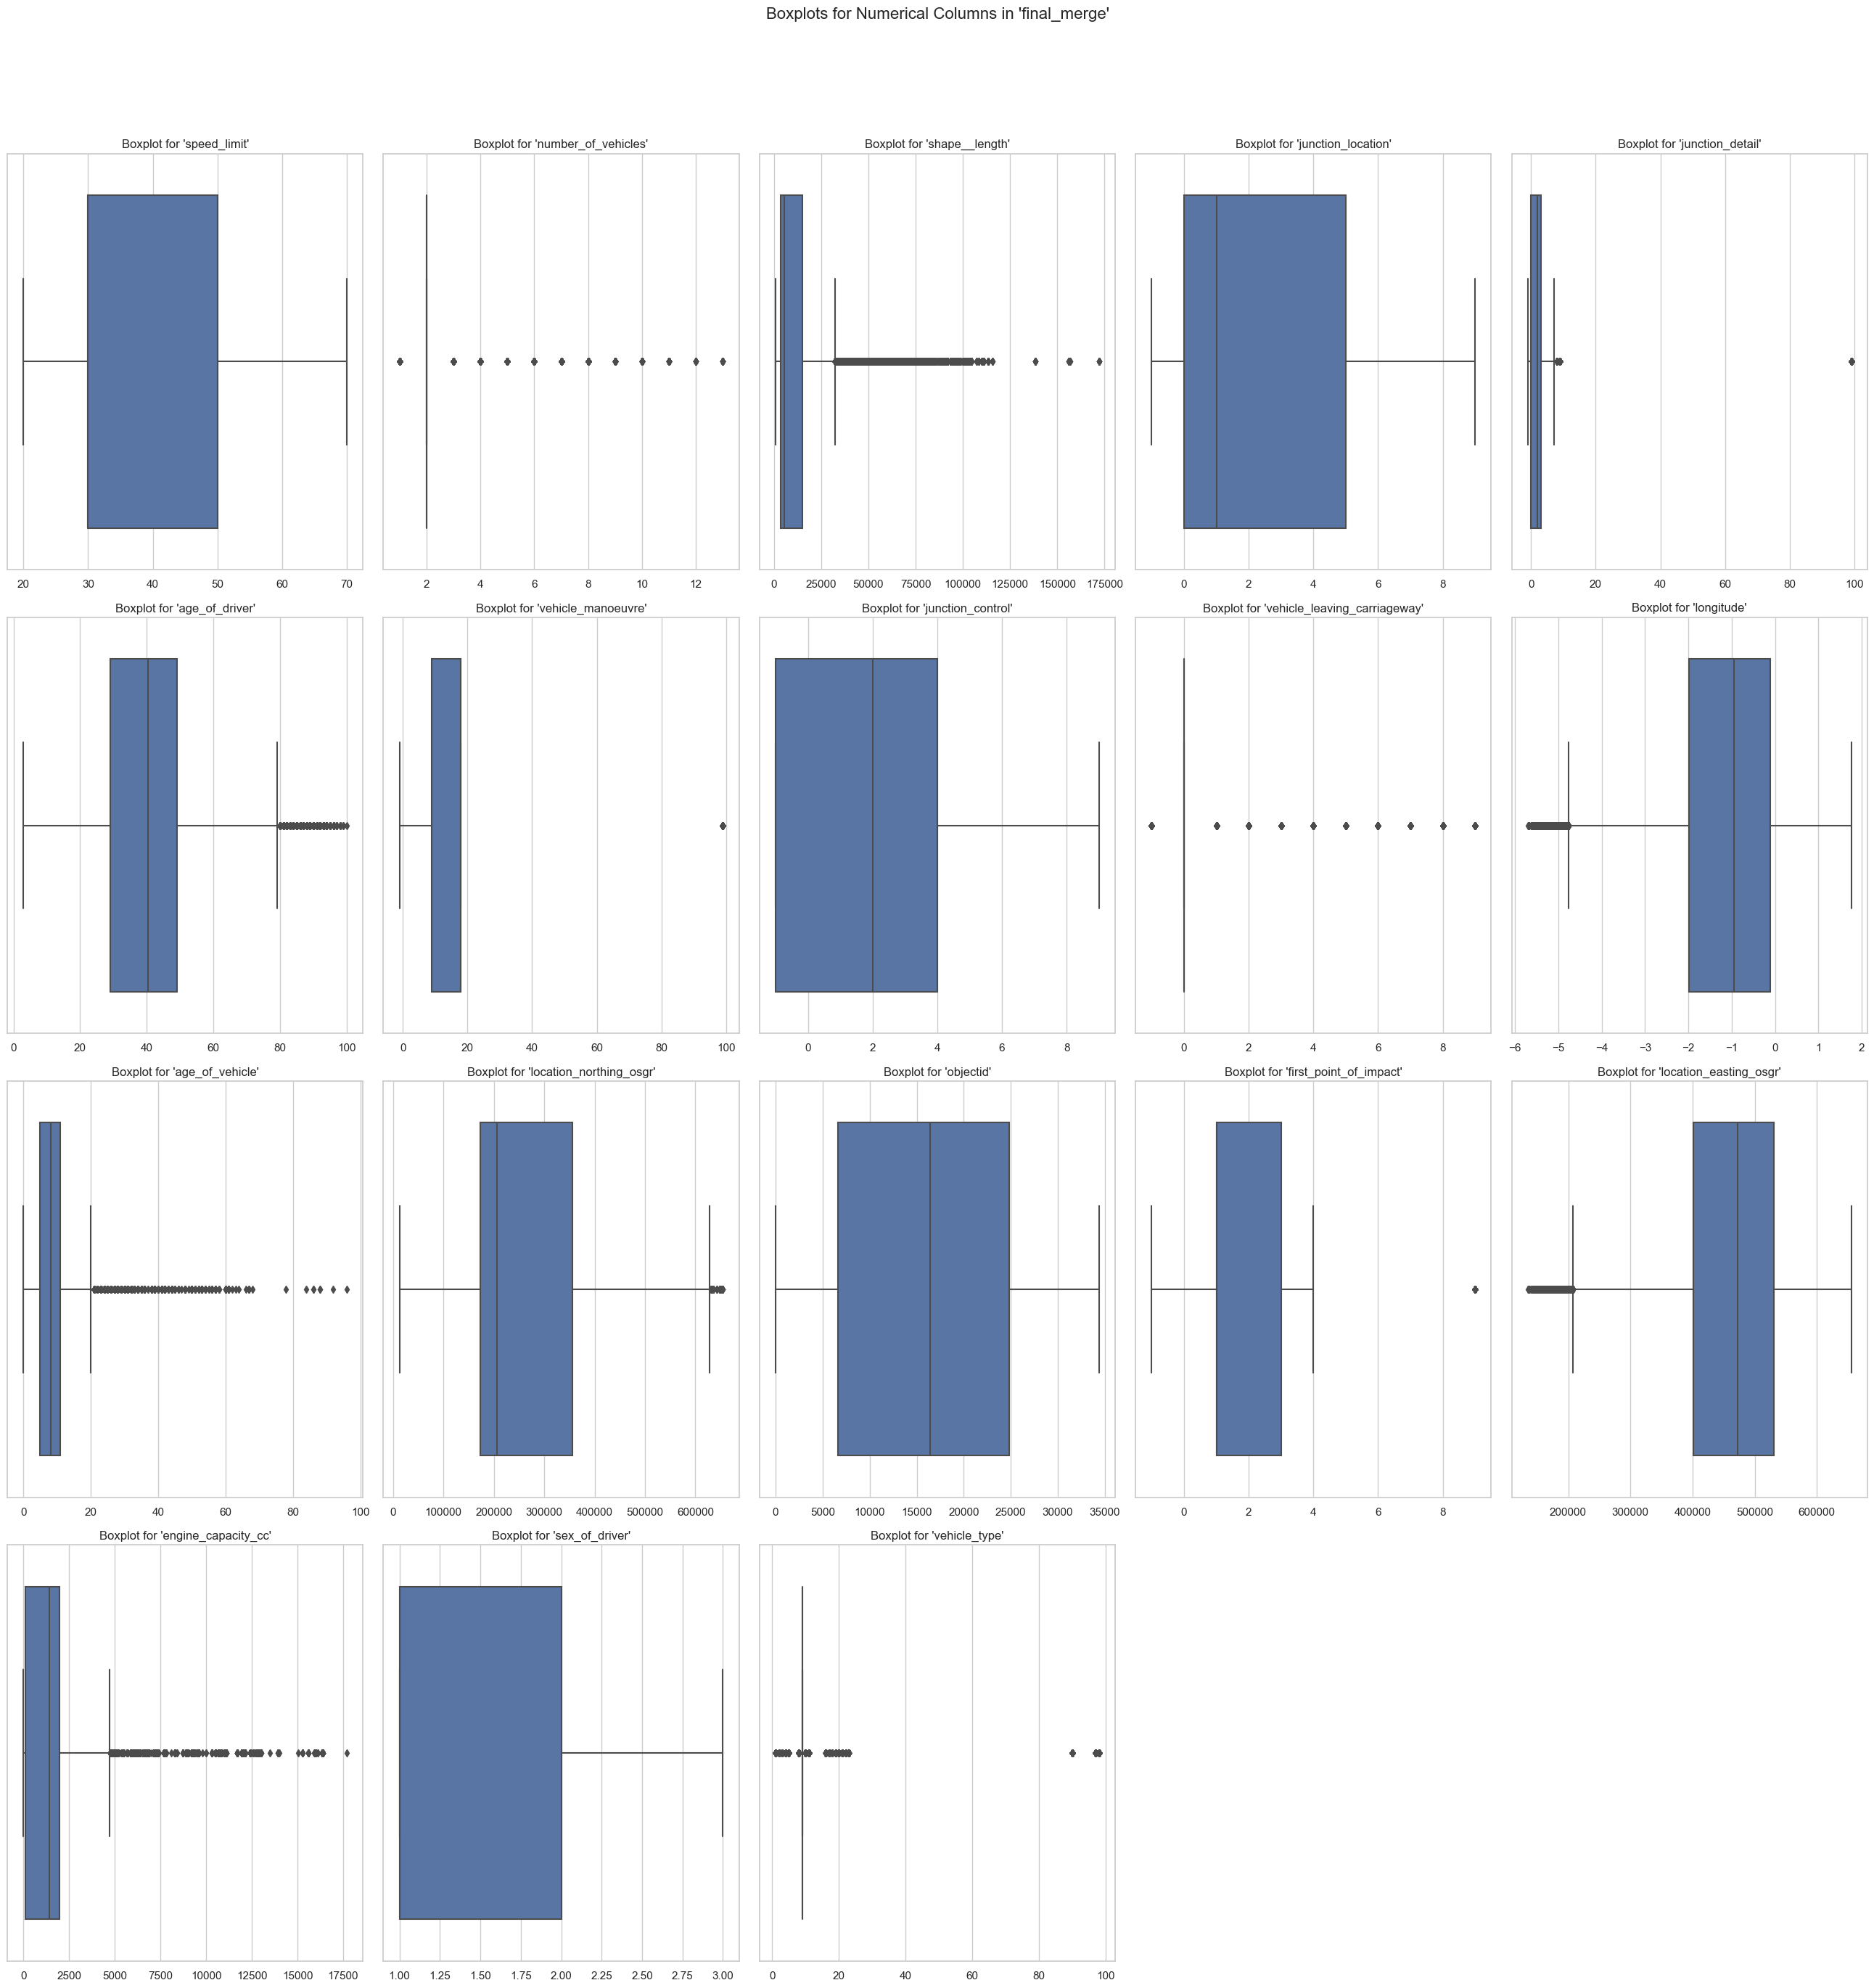

In [102]:
# Select the columns to be included in the boxplot
numerical_cols_accidents = [
    'speed_limit', 
    'number_of_vehicles', 'shape__length',  
    'junction_location',  'junction_detail', 'age_of_driver', 
    'vehicle_manoeuvre', 'junction_control', 'vehicle_leaving_carriageway', 'longitude', 
    'age_of_vehicle', 'location_northing_osgr', 'objectid', 'first_point_of_impact', 
    'location_easting_osgr', 'engine_capacity_cc', 'sex_of_driver',  'vehicle_type'
]

# Calculate the number of rows and columns needed
num_cols = 5
num_rows = int(len(numerical_cols_accidents) / num_cols) + (len(numerical_cols_accidents) % num_cols)

# Create subplots with specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(26, 7 * num_rows))
fig.suptitle("Boxplots for Numerical Columns in 'final_merge'", fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through numerical columns and plot boxplots
for idx, col in enumerate(numerical_cols_accidents):
    if idx < len(axes):
        sns.boxplot(x=final_merged_df[col], ax=axes[idx])
        axes[idx].set_title(f"Boxplot for '{col}'")
        axes[idx].set_xlabel(None)  # Remove x-label for better readability
        axes[idx].set_ylabel(None)  # Remove y-label for better readability

# Remove any empty subplots
for i in range(len(numerical_cols_accidents), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some space for the title
plt.show()


#### outliers

<AxesSubplot:xlabel='age_of_driver', ylabel='Count'>

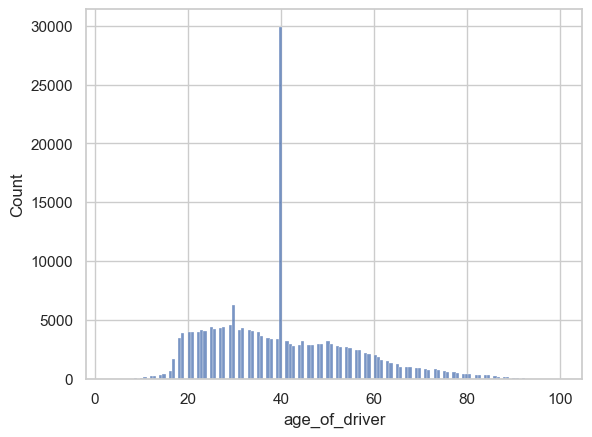

In [103]:
sns.histplot(data=final_merged_df['age_of_driver'])

<AxesSubplot:xlabel='age_of_vehicle', ylabel='Count'>

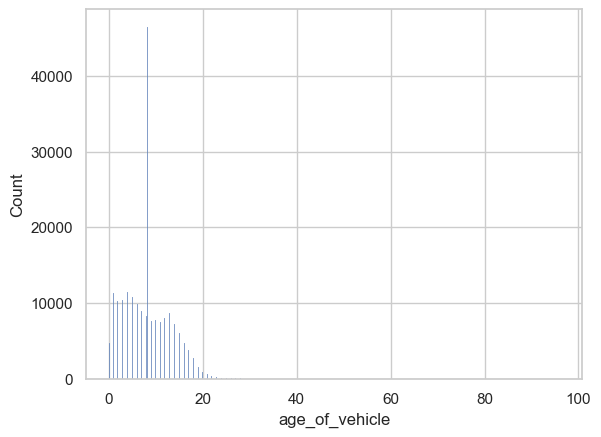

In [104]:
sns.histplot(data=final_merged_df['age_of_vehicle'])

### Multiple of Interquartile Range(IQR) method

In [105]:
def check_table_with_IQR(data_column):
    q75, q25 = np.percentile(data_column, [75, 25])
    iqr = q75 - q25

    # Get the lower quantile
    lower_quantile = q25 - (1.5 * iqr)

    # Get the upper quantile
    upper_quantile = q75 + (1.5 * iqr)

    result = {
        "The IQR value is": iqr,
        "Upper Range": upper_quantile,
        "Lower Range": lower_quantile
    }

    return result



In [106]:
numeric_columns = final_merged_df.select_dtypes(include=np.number).columns

for column in numeric_columns:
    result = check_table_with_IQR(final_merged_df[column])
    print(f"{column}: {result}")


accident_year_x: {'The IQR value is': 0.0, 'Upper Range': 2020.0, 'Lower Range': 2020.0}
location_easting_osgr: {'The IQR value is': 129112.0, 'Upper Range': 724368.0, 'Lower Range': 207920.0}
location_northing_osgr: {'The IQR value is': 183049.0, 'Upper Range': 630782.5, 'Lower Range': -101413.5}
longitude: {'The IQR value is': 1.860434, 'Upper Range': 2.673006, 'Lower Range': -4.76873}
latitude: {'The IQR value is': 1.6563450000000017, 'Upper Range': 55.584781500000005, 'Lower Range': 48.9594015}
police_force: {'The IQR value is': 40.0, 'Upper Range': 104.0, 'Lower Range': -56.0}
accident_severity: {'The IQR value is': 0.0, 'Upper Range': 3.0, 'Lower Range': 3.0}
number_of_vehicles: {'The IQR value is': 0.0, 'Upper Range': 2.0, 'Lower Range': 2.0}
number_of_casualties: {'The IQR value is': 1.0, 'Upper Range': 3.5, 'Lower Range': -0.5}
day_of_week: {'The IQR value is': 4.0, 'Upper Range': 12.0, 'Lower Range': -4.0}
local_authority_district: {'The IQR value is': 415.0, 'Upper Range': 1

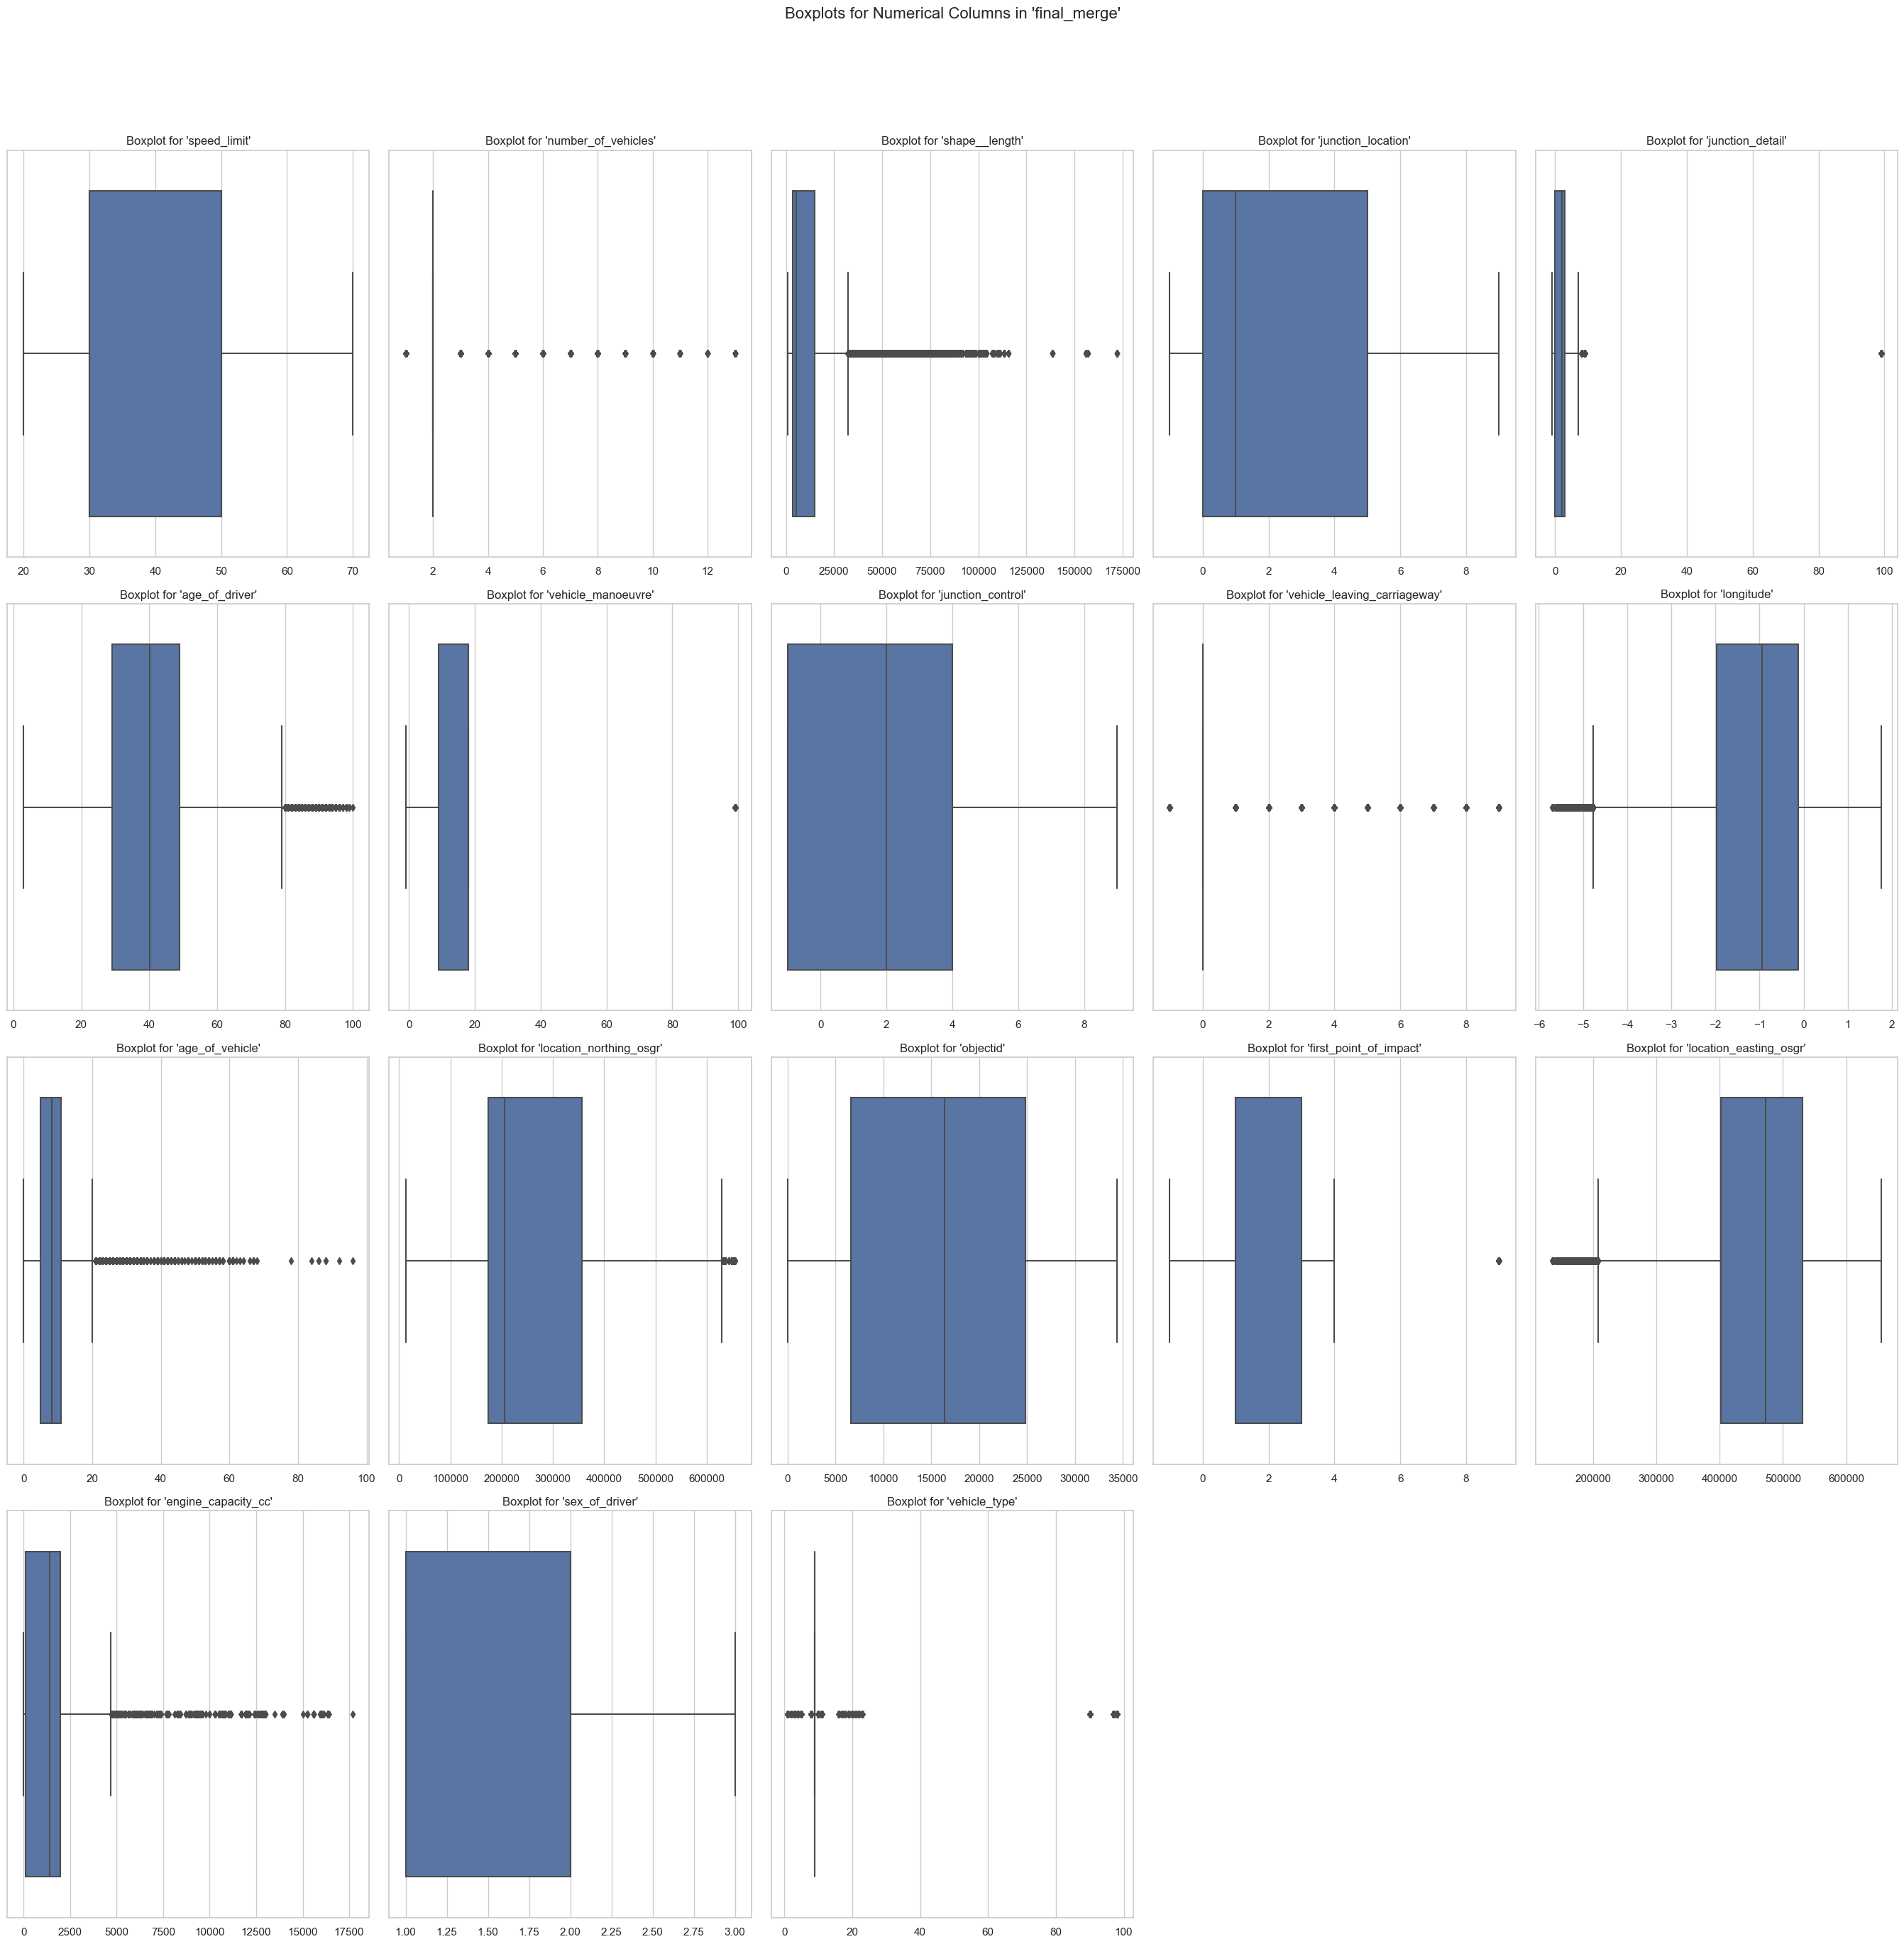

In [107]:
# Select the columns to be included in the boxplot
numerical_cols_accidents = [
    'speed_limit', 
    'number_of_vehicles', 'shape__length',  
    'junction_location',  'junction_detail', 'age_of_driver', 
    'vehicle_manoeuvre', 'junction_control', 'vehicle_leaving_carriageway', 'longitude', 
    'age_of_vehicle', 'location_northing_osgr', 'objectid', 'first_point_of_impact', 
    'location_easting_osgr', 'engine_capacity_cc', 'sex_of_driver',  'vehicle_type'
]

# Calculate the number of rows and columns needed
num_cols = 5
num_rows = int(len(numerical_cols_accidents) / num_cols) + (len(numerical_cols_accidents) % num_cols)

# Create subplots with specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(27, 7 * num_rows))
fig.suptitle("Boxplots for Numerical Columns in 'final_merge'", fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through numerical columns and plot boxplots
for idx, col in enumerate(numerical_cols_accidents):
    if idx < len(axes):
        sns.boxplot(x=final_merged_df[col], ax=axes[idx])
        axes[idx].set_title(f"Boxplot for '{col}'")
        axes[idx].set_xlabel(None)  # Remove x-label for better readability
        axes[idx].set_ylabel(None)  # Remove y-label for better readability

# Remove any empty subplots
for i in range(len(numerical_cols_accidents), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some space for the title
plt.show()


### Grubbs' Test

In [108]:
def get_Grubbs(a):
    avg = a.mean()
    absvalues = abs(a - avg)
    stdev = a.std()
    
    if stdev == 0:
        Grubbs = float('inf')  # Handle the case where stdev is zero
    else:
        maxvalue = max(a)
        Grubbs = maxvalue / stdev
    
    return Grubbs

def get_critical_G(size, alpha):
    tdist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(tdist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(tdist))
    critical_value = numerator / denominator
    print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

dataframes = [final_merged_df]

for df in dataframes:
    numeric_columns = df.select_dtypes(include=np.number).columns
    
    for column in numeric_columns:
        G_value = get_Grubbs(df[column])
        G_critical = get_critical_G(len(df[column]), 0.05)
        
        if G_value < G_critical:
            print(f"{column}: Accept the null hypothesis")
        else:
            print(f"{column}: Reject the null hypothesis")


Grubbs Critical Value: 5.159335165158971
accident_year_x: Reject the null hypothesis
Grubbs Critical Value: 5.159335165158971
location_easting_osgr: Reject the null hypothesis
Grubbs Critical Value: 5.159335165158971
location_northing_osgr: Reject the null hypothesis
Grubbs Critical Value: 5.159335165158971
longitude: Accept the null hypothesis
Grubbs Critical Value: 5.159335165158971
latitude: Reject the null hypothesis
Grubbs Critical Value: 5.159335165158971
police_force: Accept the null hypothesis
Grubbs Critical Value: 5.159335165158971
accident_severity: Reject the null hypothesis
Grubbs Critical Value: 5.159335165158971
number_of_vehicles: Reject the null hypothesis
Grubbs Critical Value: 5.159335165158971
number_of_casualties: Reject the null hypothesis
Grubbs Critical Value: 5.159335165158971
day_of_week: Accept the null hypothesis
Grubbs Critical Value: 5.159335165158971
local_authority_district: Accept the null hypothesis
Grubbs Critical Value: 5.159335165158971
first_road_c

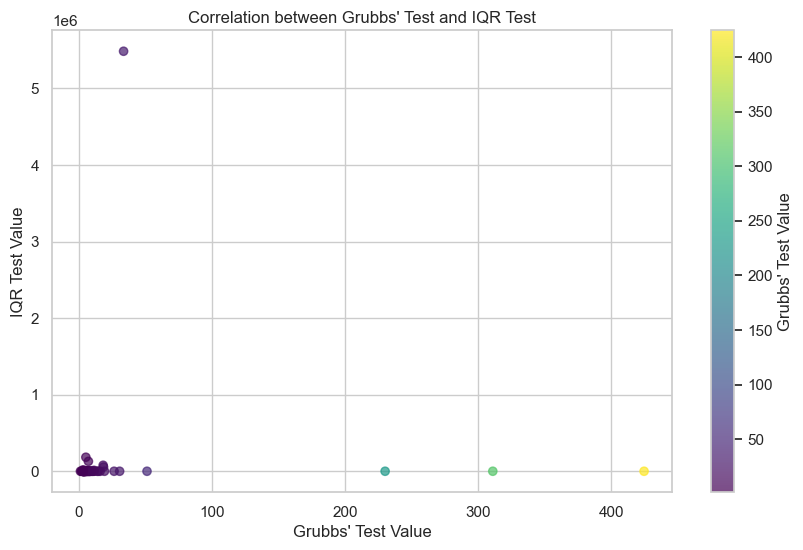

In [109]:
# Function to calculate Grubbs' test value
def get_Grubbs(a):
    avg = a.mean()
    absvalues = abs(a - avg)
    stdev = a.std()
    
    if stdev == 0:
        Grubbs = float('inf')  # Handle the case where stdev is zero
    else:
        maxvalue = max(a)
        Grubbs = maxvalue / stdev
    
    return Grubbs

# Function to calculate critical value for Grubbs' test
def get_critical_G(size, alpha):
    tdist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(tdist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(tdist))
    critical_value = numerator / denominator
    return critical_value

dataframes = [final_merged_df]

grubbs_values = []
iqr_values = []

# Calculate Grubbs' test value and IQR for each numeric column
for df in dataframes:
    numeric_columns = df.select_dtypes(include=np.number).columns
    
    for column in numeric_columns:
        G_value = get_Grubbs(df[column])
        G_critical = get_critical_G(len(df[column]), 0.05)
        
        IQR = stats.iqr(df[column])
        
        grubbs_values.append(G_value)
        iqr_values.append(IQR)

# Create a scatter plot with colors
plt.figure(figsize=(10, 6))
plt.scatter(grubbs_values, iqr_values, c=grubbs_values, cmap='viridis', alpha=0.7)
plt.xlabel("Grubbs' Test Value")
plt.ylabel("IQR Test Value")
plt.title("Correlation between Grubbs' Test and IQR Test")
plt.colorbar(label="Grubbs' Test Value")
plt.grid(True)
plt.show()


### Can you develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?

In [110]:
y_label = final_merged_df['accident_severity']==1

In [111]:
accident_data_drop = final_merged_df

In [112]:
accident_data_bal=accident_data_bal.dropna()

In [113]:
accident_data_bal, y_bal = RandomUnderSampler().fit_resample(accident_data_drop, y_label)

In [114]:
accident_data_bal = accident_data_bal.drop(['accident_severity', 'did_police_officer_attend_scene_of_accident', 'casualty_severity'], axis = 1)

In [115]:
accident_data_bal = accident_data_bal.select_dtypes([np.number])

In [116]:
accident_data_bal

accident_year_x  location_easting_osgr  location_northing_osgr  \
0                2020               523993.0                196409.0   
1                2020               526334.0                192374.0   
2                2020               330175.0                136170.0   
3                2020               399226.0                395851.0   
4                2020               326067.0                388967.0   
...               ...                    ...                     ...   
7339             2020               322000.0                243260.0   
7340             2020               322000.0                243260.0   
7341             2020               322000.0                243260.0   
7342             2020               322000.0                243260.0   
7343             2020               322000.0                243260.0   

      longitude   latitude  police_force  number_of_vehicles  \
0     -0.209043  51.652810             1                   1   
1     -0.176677  51.616027             1                   3   
2     -2.999044  51.120537            52                   2   
3     -2.013123  53.459424             6                   2   
4     -3.113217  53.392357             5                   2   
...         ...        ...           ...                 ...   
7339  -3.139679  52.082186            63                   6   
7340  -3.139679  52.082186            63                   6   
7341  -3.139679  52.082186            63                   6   
7342  -3.139679  52.082186            63                   6   
7343  -3.139679  52.082186            63                   6   

      number_of_casualties  day_of_week  local_authority_district  ...  \
0                        1            4                        30  ...   
1                        3            3                        30  ...   
2                        1            5                       607  ...   
3                        1            1                       110  ...   
4                        1            1                        95  ...   
...                    ...          ...                       ...  ...   
7339                     1            4                       753  ...   
7340                     1            4                       753  ...   
7341                     1            4                       753  ...   
7342                     1            4                       753  ...   
7343                     1            4                       753  ...   

      pedestrian_movement  car_passenger  bus_or_coach_passenger  \
0                       3              0                       0   
1                       0              0                       0   
2                       0              0                       0   
3                       0              0                       0   
4                       0              0                       0   
...                   ...            ...                     ...   
7339                    0              0                       0   
7340                    0              0                       0   
7341                    0              0                       0   
7342                    0              0                       0   
7343                    0              0                       0   

      pedestrian_road_maintenance_worker  casualty_type  \
0                                      0              0   
1                                      0              1   
2                                      0              3   
3                                      0              9   
4                                      0              2   
...                                  ...            ...   
7339                                   0              9   
7340                                   0              9   
7341                                   0              9   
7342                                   0              9   
7343             

### Random Forest and Naive Bayesclassifier

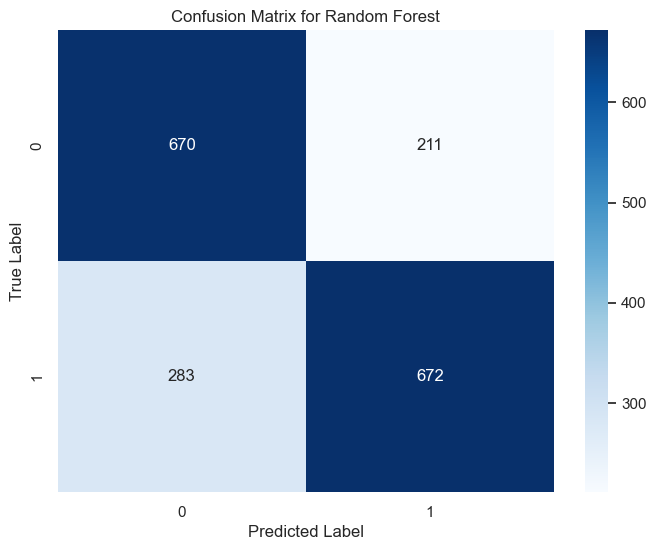

Classification Report for Random Forest:
              precision    recall  f1-score   support

       False       0.70      0.76      0.73       881
        True       0.76      0.70      0.73       955

    accuracy                           0.73      1836
   macro avg       0.73      0.73      0.73      1836
weighted avg       0.73      0.73      0.73      1836



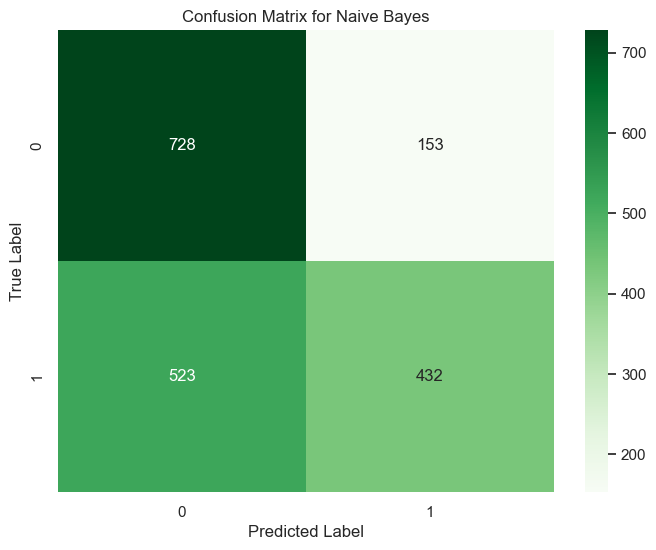

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

       False       0.58      0.83      0.68       881
        True       0.74      0.45      0.56       955

    accuracy                           0.63      1836
   macro avg       0.66      0.64      0.62      1836
weighted avg       0.66      0.63      0.62      1836



In [117]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(accident_data_bal, y_bal, test_size=0.25, random_state=1)

# Create the Random Forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=100, random_state=1)

# Train the Random Forest classifier
rf.fit(X_train, y_train)

# Make predictions on the test set using Random Forest
y_pred_rf = rf.predict(X_test)

# Calculate the accuracy of Random Forest
acc_rf = round(rf.score(X_train, y_train) * 100, 2)

# Create the Naive Bayes classifier
nb = GaussianNB()

# Train the Naive Bayes classifier
nb.fit(X_train, y_train)

# Make predictions on the test set using Naive Bayes
y_pred_nb = nb.predict(X_test)

# Calculate the accuracy of Naive Bayes
acc_nb = round(nb.score(X_train, y_train) * 100, 2)

# Visualize the confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report for Random Forest
print('Classification Report for Random Forest:')
print(classification_report(y_test, y_pred_rf))

# Visualize the confusion matrix for Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report for Naive Bayes
print('Classification Report for Naive Bayes:')
print(classification_report(y_test, y_pred_nb))


### stacking classifier

dtree: 0.80 0.020
knn: 0.73 0.017
bayes: 0.65 0.017
Stacking: 0.81 0.015


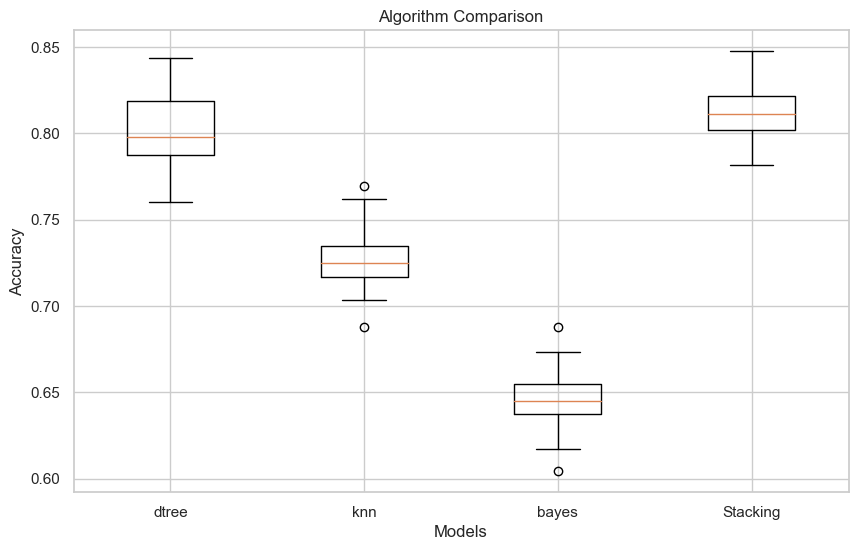

In [118]:
# Code 1: evaluate_model
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, error_score='raise')
    return scores

# Code 2: get_models
def get_models():
    models = dict()
    models['dtree'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['bayes'] = GaussianNB()
    return models

# Code 3: get_stacking
def get_stacking():
    level0 = []
    level0.append(('dtree', DecisionTreeClassifier()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('bayes', GaussianNB()))
    
    level1 = LogisticRegression()
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# Get the models
models = get_models()

names = []
results = []
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    print(f"{name}: {np.mean(scores):.2f} {np.std(scores):.3f}")
    names.append(name)
    results.append(scores)

# Evaluate the stacking classifier
model_stacking = get_stacking()
scores_stacking = evaluate_model(model_stacking, X_train, y_train)
print(f"Stacking: {np.mean(scores_stacking):.2f} {np.std(scores_stacking):.3f}")
names.append('Stacking')
results.append(scores_stacking)

# Compare the algorithms
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()


### References
#### https://docs.python.org/3/library/sqlite3.html
#### https://stackoverflow.com/questions/41681693/pandas-isnull-sum-with-column-headers
#### https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
#### https://stackoverflow.com/questions/40686000/recurring-custom-color-palette-for-seaborn-python-matplotlib
#### https://stackoverflow.com/questions/51736396/subplots-in-matplotlib-give-valueerror-not-enough-values-to-unpack
#### https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
#### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#### https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
#### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#### https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
#### https://www.geeksforgeeks.org/python-def-keyword/
#### https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/mean-center.htm